# Annotation

Consider a binary classification problem. We will fit a predictor and use it to assign a weight score to each node in each instance; this operation is referred to as "annotation". For illustration purposes we will display a few annotated graphs. We will see that building a predictor on the annotated instances can increase the predictive performance.

In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

load data and convert it to graphs

In [2]:
pos = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_pos.gspan'
neg = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_neg.gspan'

from eden.converter.graph.gspan import gspan_to_eden
iterable_pos = gspan_to_eden( pos )
iterable_neg = gspan_to_eden( neg )

#split train/test
train_test_split=0.7
from eden.util import random_bipartition_iter
iterable_pos_train, iterable_pos_test = random_bipartition_iter(iterable_pos, relative_size=train_test_split)
iterable_neg_train, iterable_neg_test = random_bipartition_iter(iterable_neg, relative_size=train_test_split)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de


setup the vectorizer

In [3]:
from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3)

In [4]:
%%time
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train)
iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test)
iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test)

from eden.util import fit,estimate
estimator = fit(iterable_pos_train_, iterable_neg_train_, vectorizer)
estimate(iterable_pos_test_, iterable_neg_test_, estimator, vectorizer)

Test set
Instances: 1300 ; Features: 1048577 with an avg of 218 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.77      0.85      0.81       580
          1       0.87      0.80      0.83       720

avg / total       0.83      0.82      0.82      1300

APR: 0.911
ROC: 0.898
Cross-validated estimate
            accuracy: 0.792 +- 0.023
           precision: 0.826 +- 0.021
              recall: 0.790 +- 0.042
                  f1: 0.807 +- 0.024
   average_precision: 0.874 +- 0.027
             roc_auc: 0.859 +- 0.027
CPU times: user 8.63 s, sys: 2.23 s, total: 10.9 s
Wall time: 23.7 s


annotate instances and list all resulting graphs

display one graph as an example. Color the vertices using the annotated 'importance' attribute.

In [5]:
score_threshold=1

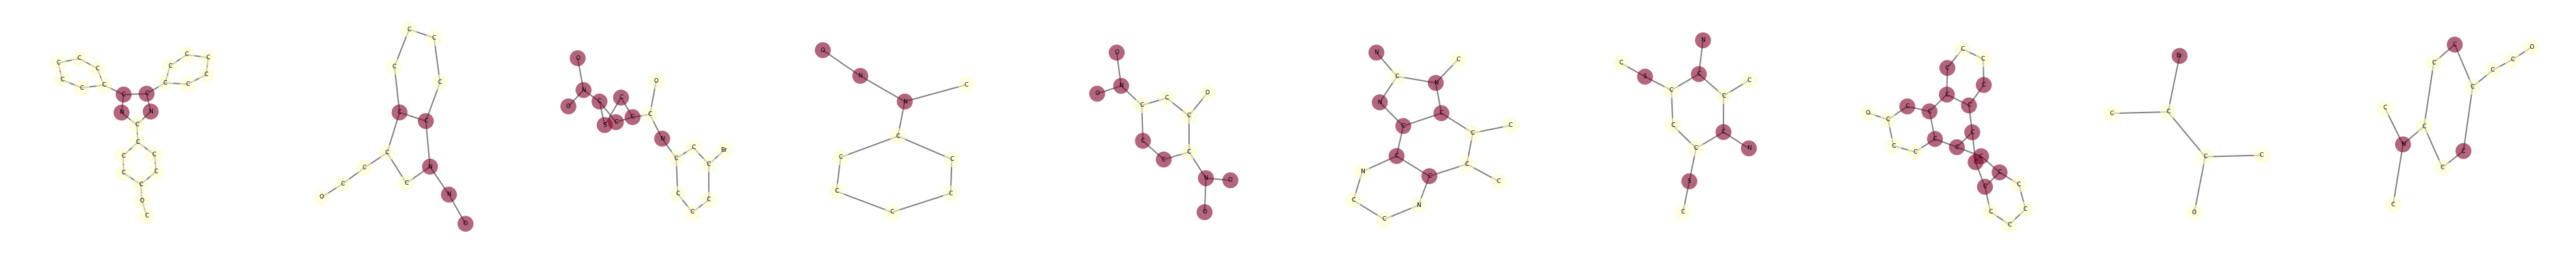

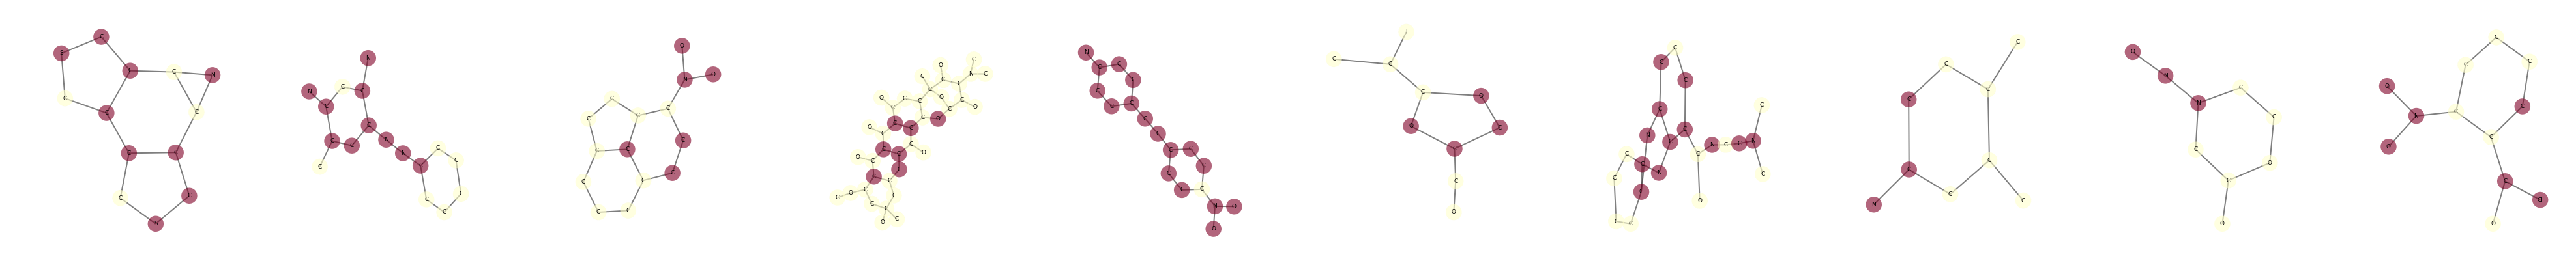

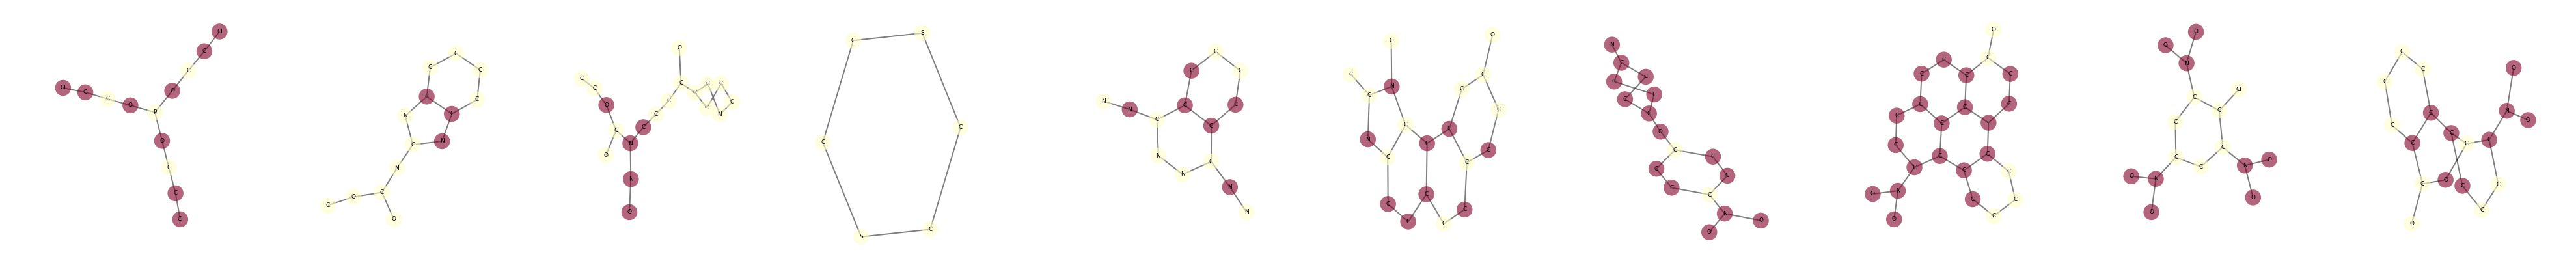

In [6]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

import itertools 
graphs = itertools.islice(graphs, 30)

from eden.modifier.graph.vertex_attributes import colorize_binary
graphs = colorize_binary(graph_list = graphs, output_attribute = 'color_value', input_attribute='importance', level=score_threshold)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=10, size=7, vertex_color='color_value', prog='neato')

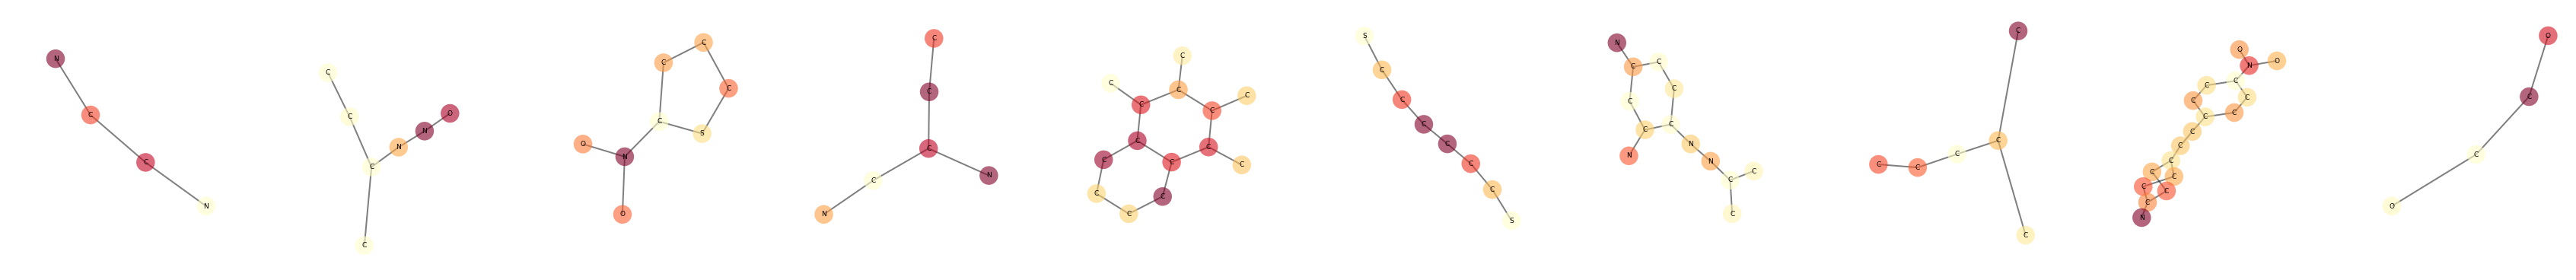

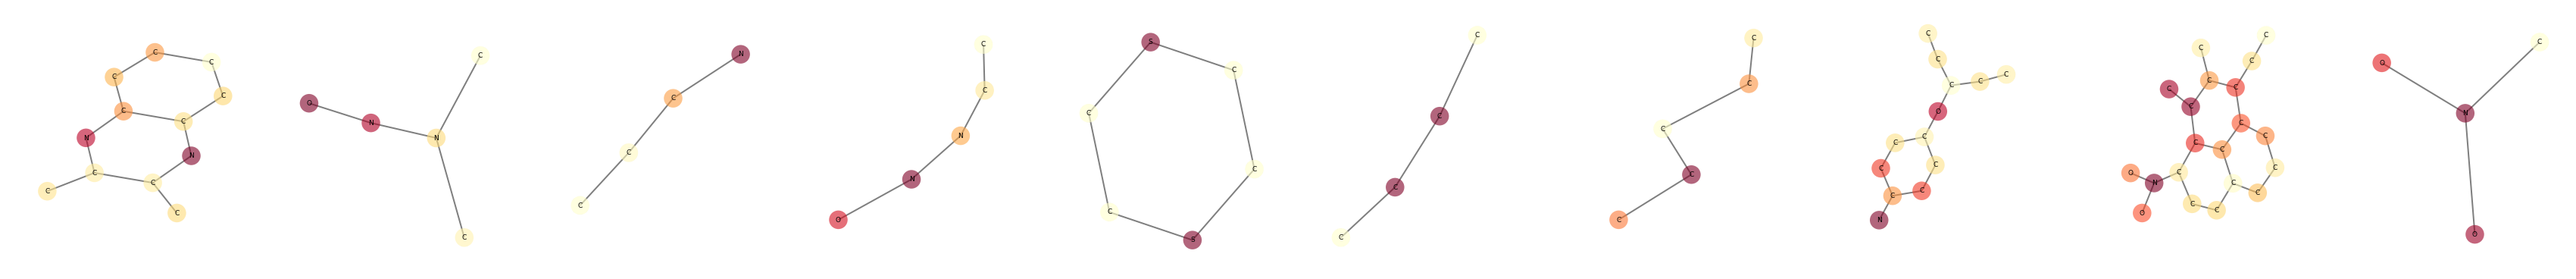

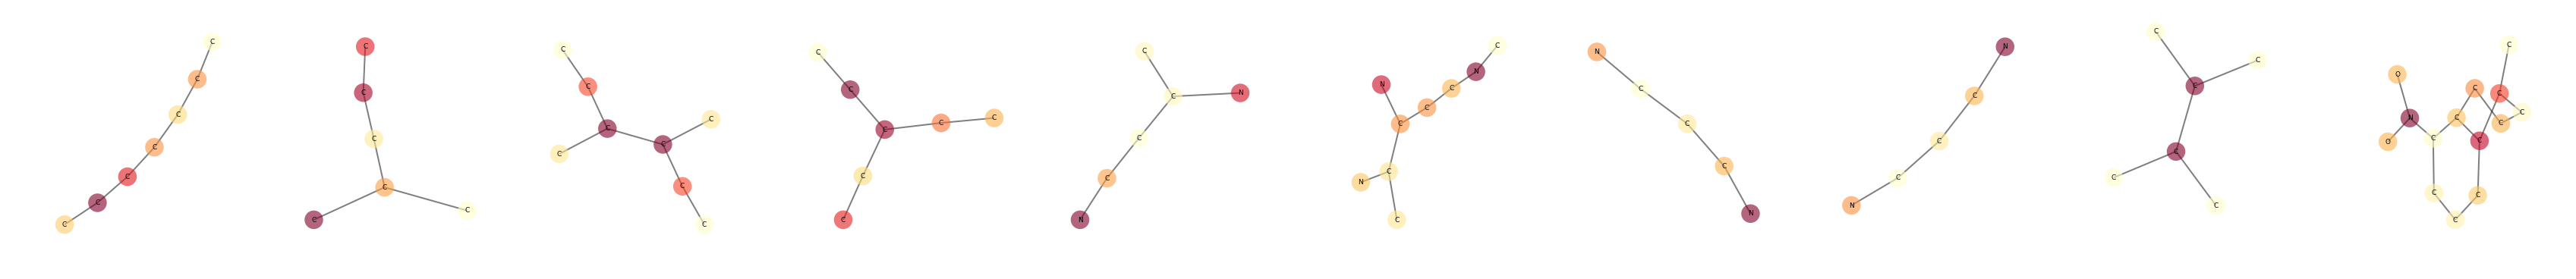

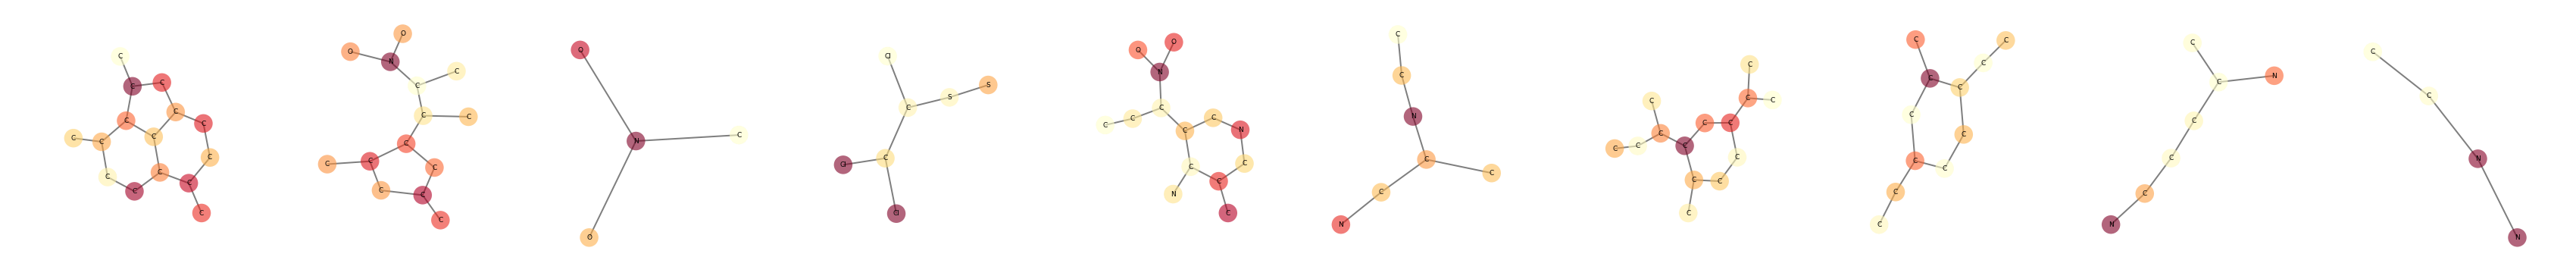

In [7]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.components(iterable_pos_train_, estimator=estimator, score_threshold=score_threshold, min_size=4)

import itertools 
graphs = itertools.islice( graphs, 40)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=10, size=6, vertex_color='importance', prog='neato')

In [29]:
%%time
# cluster the components
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
graphs = vectorizer.components(iterable_pos_train_, estimator=estimator, score_threshold=score_threshold, min_size=4)
graphs = list(graphs)
data_matrix = vectorizer.transform(graphs)
print data_matrix.shape

(1089, 1048577)
CPU times: user 32.2 s, sys: 1.98 s, total: 34.2 s
Wall time: 34.3 s


In [38]:
%%time
ALGO='DBSCAN'
if ALGO=='DBSCAN':
    distance_std_factor = 2
    import numpy as np
    from sklearn.metrics.pairwise import pairwise_distances
    distance_matrix = pairwise_distances(data_matrix)
    eps = np.mean(distance_matrix) - distance_std_factor * np.std(distance_matrix)
    print 'eps:%.4f'%eps
    from sklearn.cluster import DBSCAN
    clust = DBSCAN(eps=eps, min_samples=3)
    cluster_ids = clust.fit_predict(data_matrix)
elif ALGO=='KMEANS':
    from sklearn.cluster import MiniBatchKMeans
    clust = MiniBatchKMeans(n_clusters=80)
    cluster_ids = clust.fit_predict(data_matrix)


print len(cluster_ids)
print 'num clusters: %d' % max(cluster_ids)
from eden.util import report_base_statistics
print report_base_statistics(cluster_ids).replace('\t','\n')

eps:1.0846
1089
num clusters: 39
class: 0 count:3 (0.00)
class: 1 count:17 (0.02)
class: 2 count:618 (0.57)
class: 3 count:11 (0.01)
class: 4 count:10 (0.01)
class: 5 count:5 (0.00)
class: 6 count:15 (0.01)
class: 7 count:4 (0.00)
class: 8 count:10 (0.01)
class: 9 count:14 (0.01)
class: 10 count:17 (0.02)
class: 11 count:3 (0.00)
class: 12 count:19 (0.02)
class: 13 count:19 (0.02)
class: 14 count:12 (0.01)
class: 15 count:6 (0.01)
class: 16 count:32 (0.03)
class: 17 count:3 (0.00)
class: 18 count:5 (0.00)
class: 19 count:4 (0.00)
class: 20 count:9 (0.01)
class: 21 count:26 (0.02)
class: 22 count:18 (0.02)
class: 23 count:8 (0.01)
class: 24 count:5 (0.00)
class: 25 count:21 (0.02)
class: 26 count:6 (0.01)
class: 27 count:8 (0.01)
class: 28 count:4 (0.00)
class: 29 count:3 (0.00)
class: 30 count:3 (0.00)
class: 31 count:5 (0.00)
class: 32 count:7 (0.01)
class: 33 count:3 (0.00)
class: 34 count:3 (0.00)
class: 35 count:5 (0.00)
class: 36 count:3 (0.00)
class: 37 count:3 (0.00)
class: 38 c

cluster id: 0  num: 3


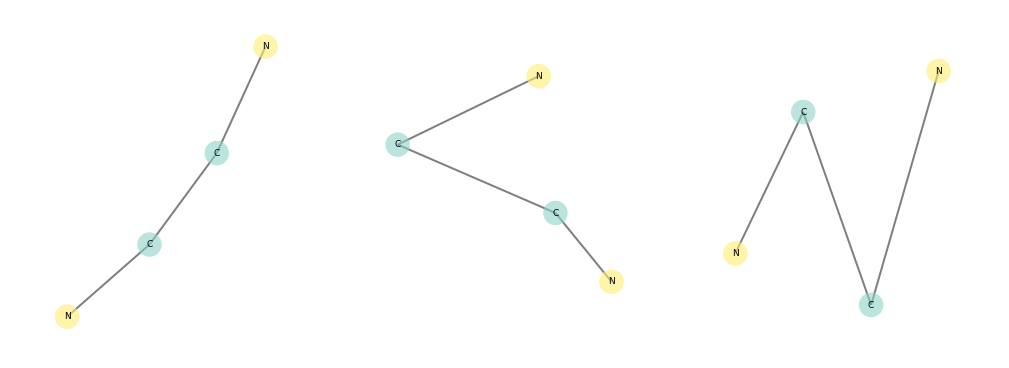

cluster id: 1  num: 17


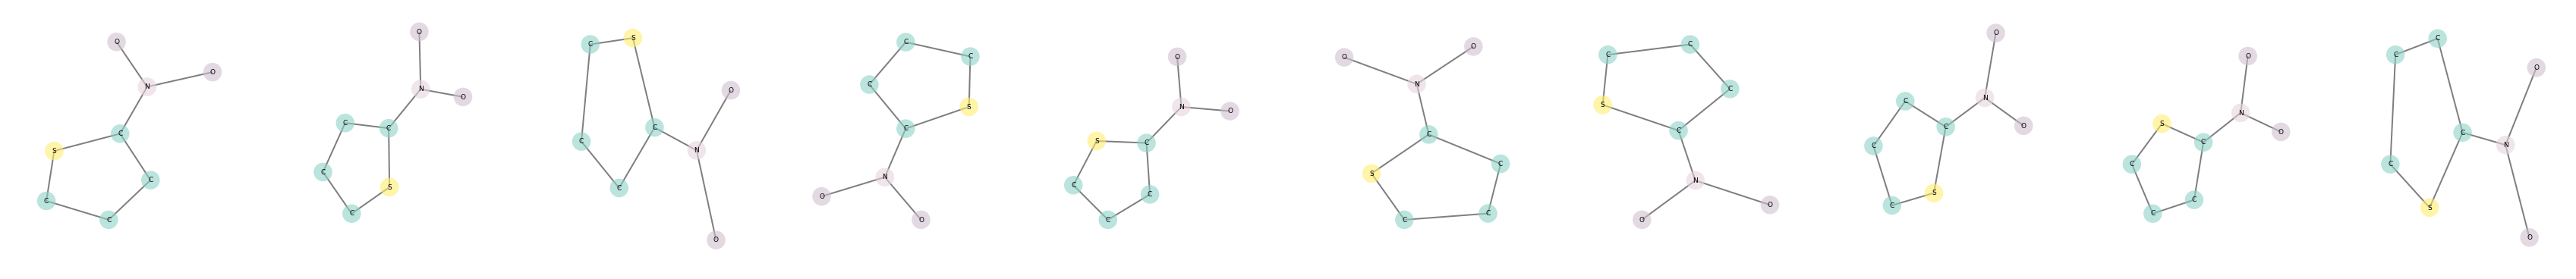

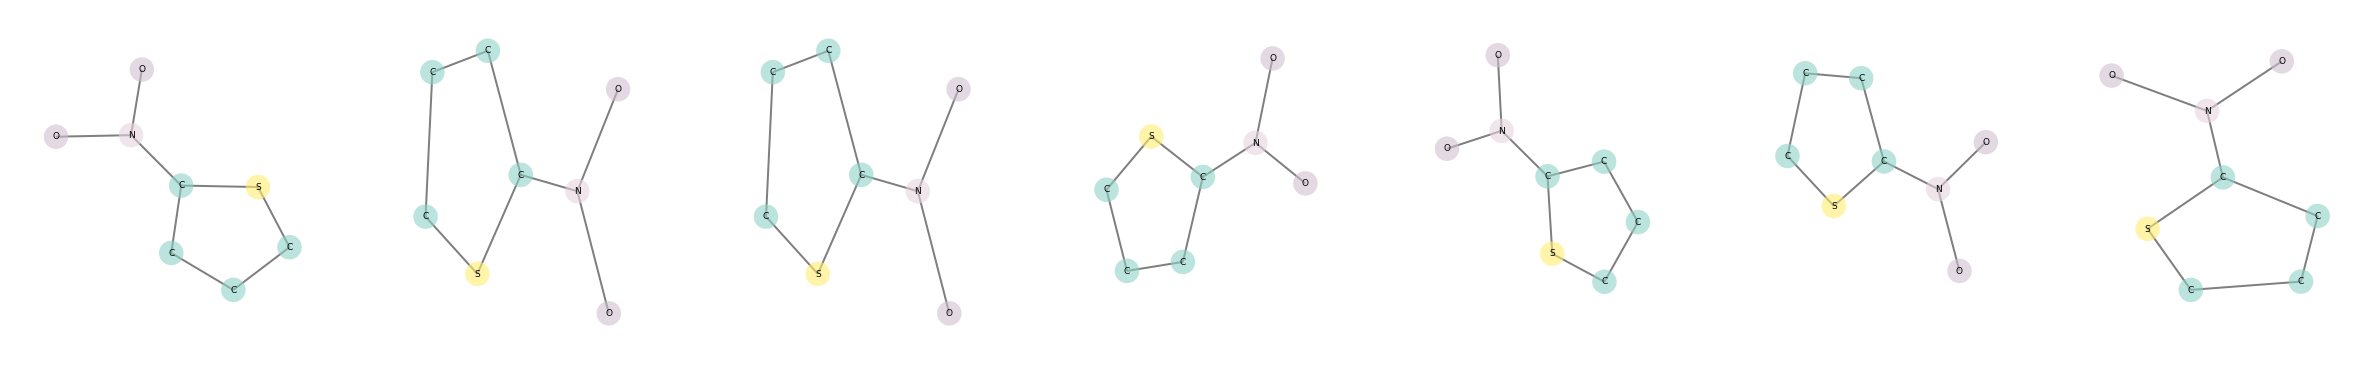

cluster id: 2  num: 618


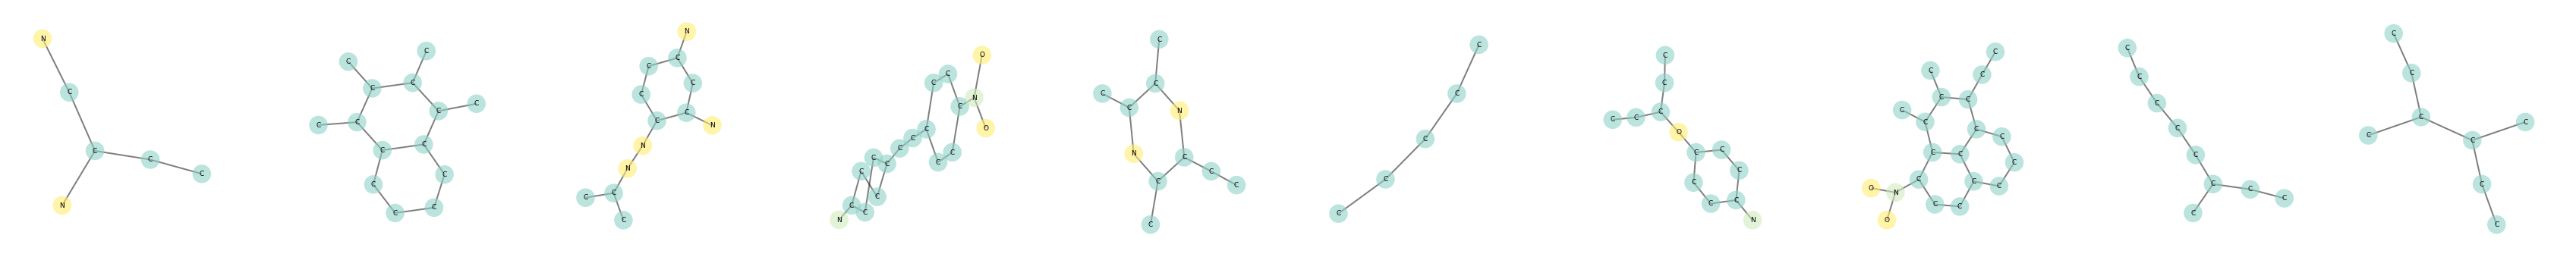

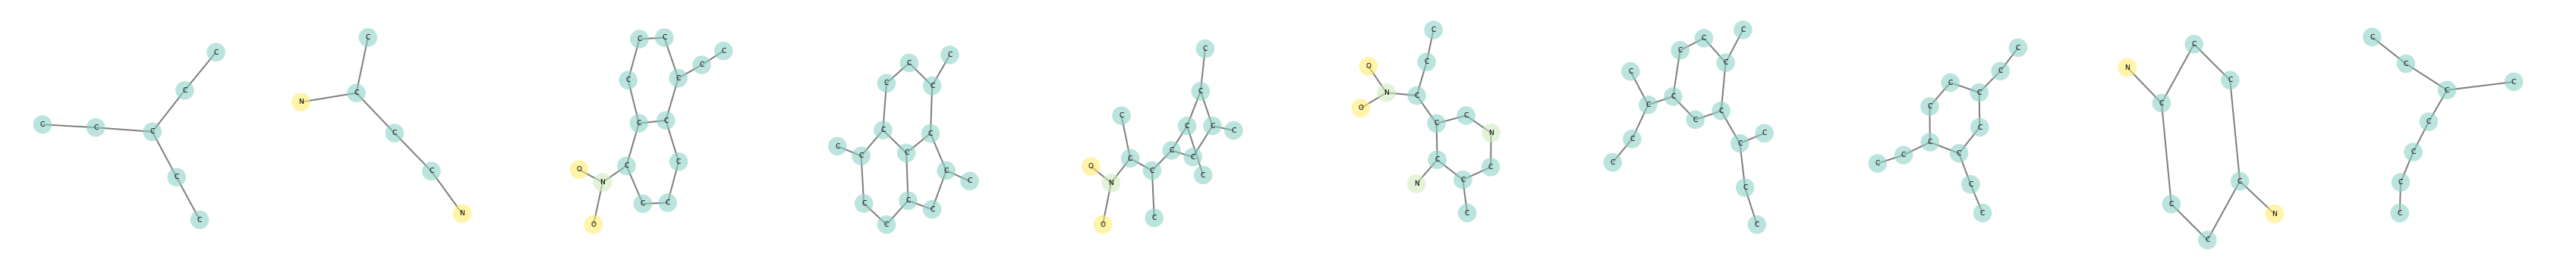

cluster id: 3  num: 11


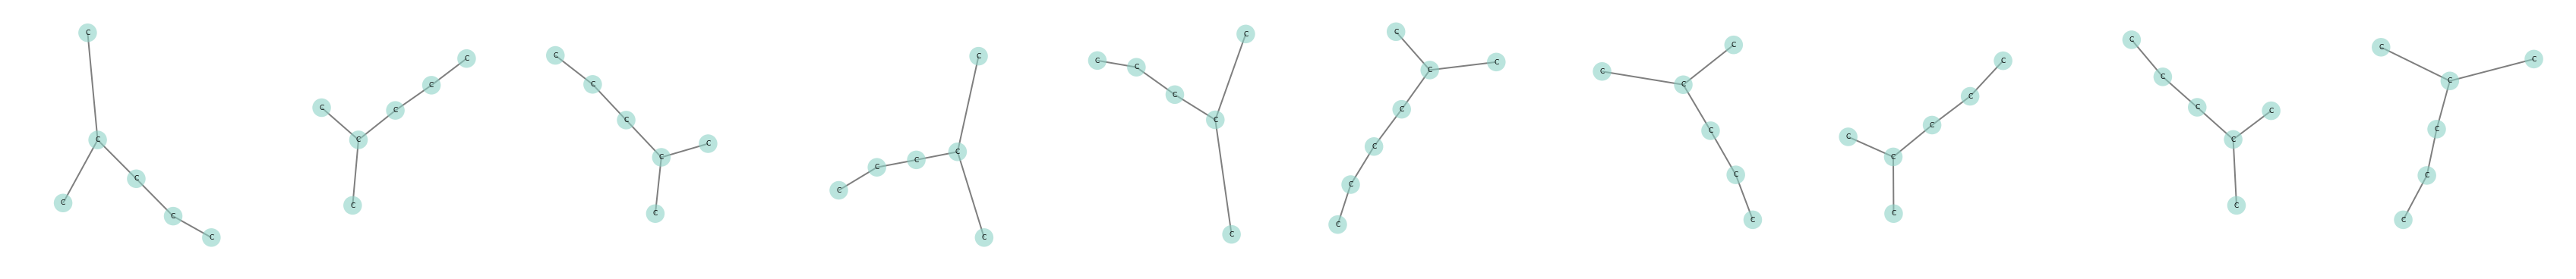

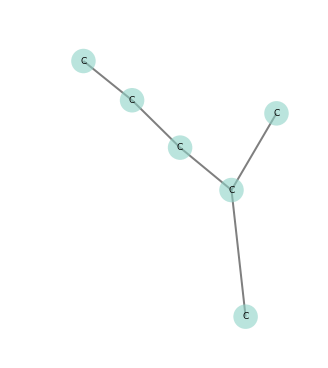

cluster id: 4  num: 10


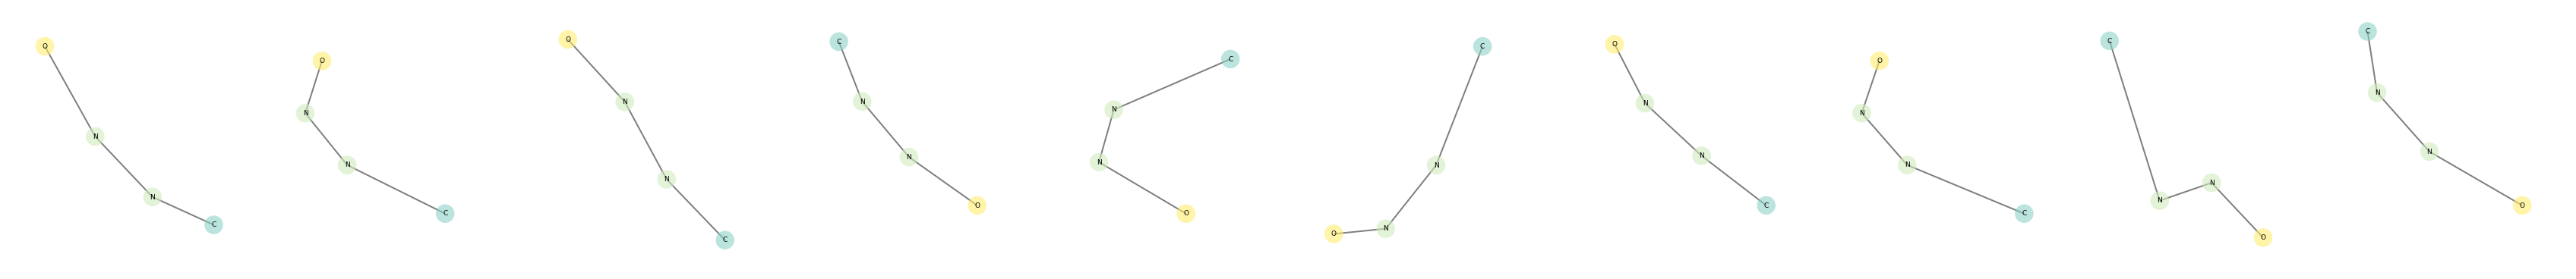

cluster id: 5  num: 5


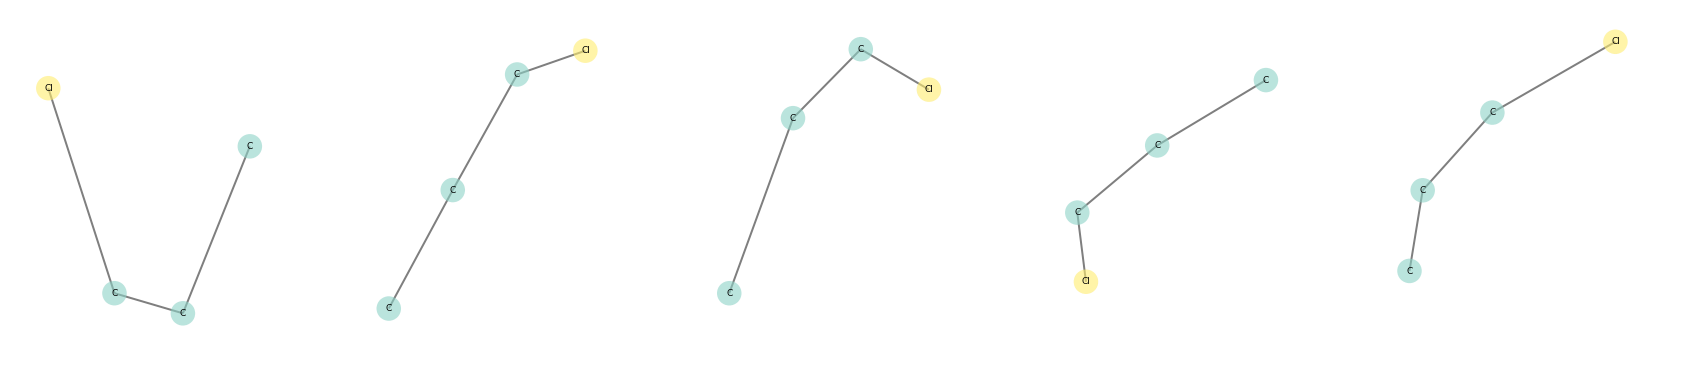

cluster id: 6  num: 15


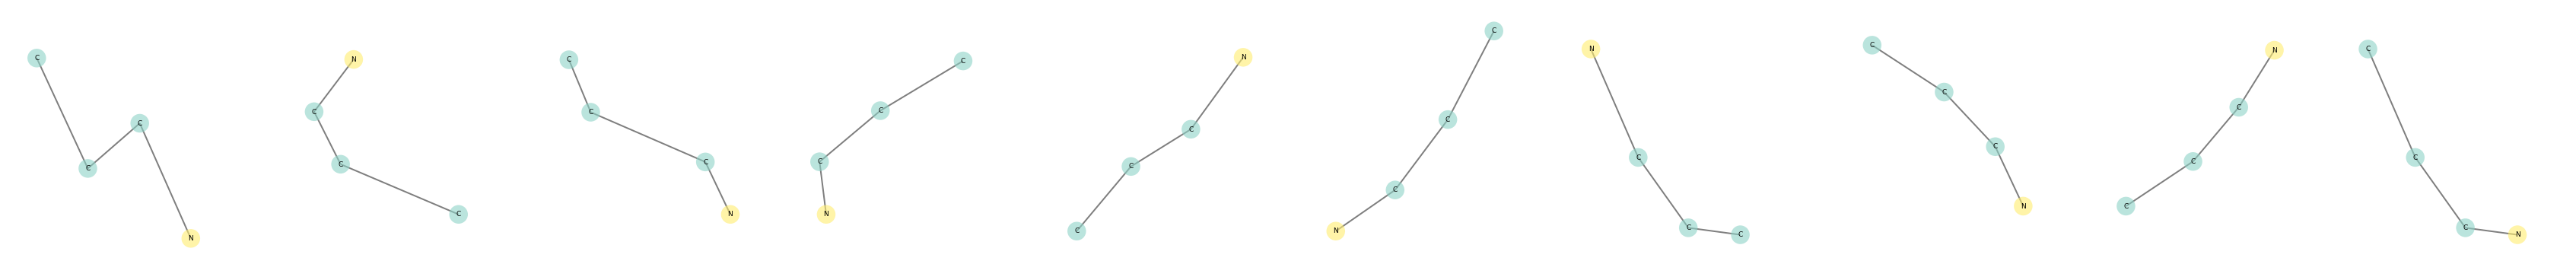

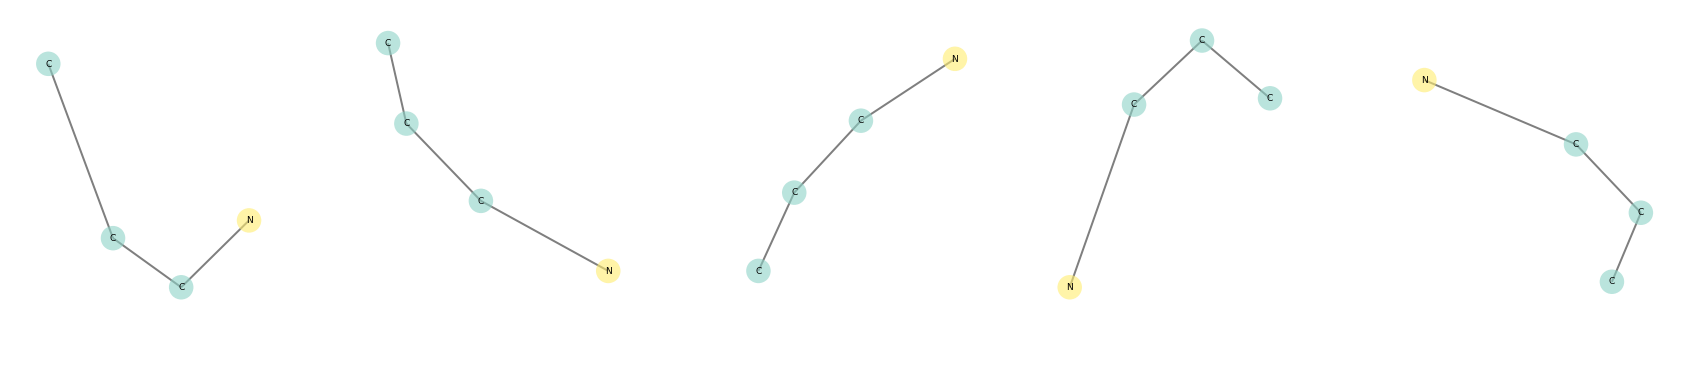

cluster id: 7  num: 4


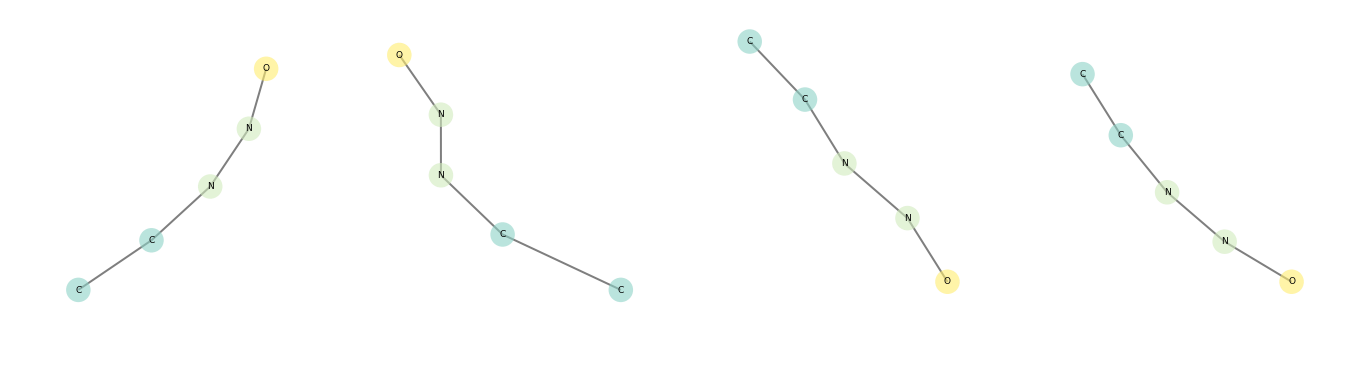

cluster id: 8  num: 10


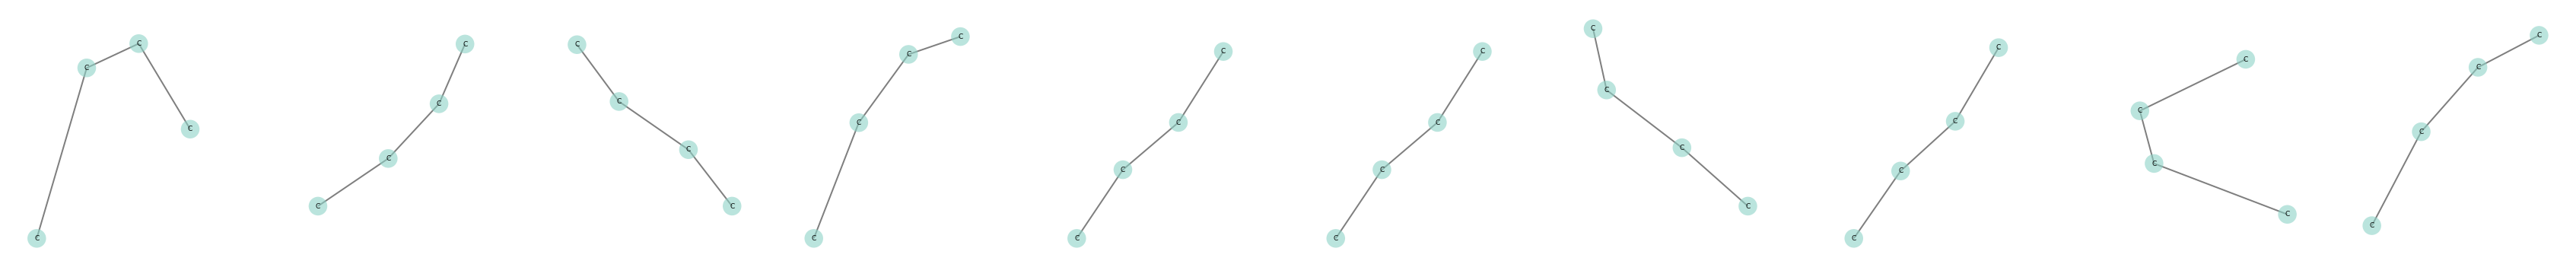

cluster id: 9  num: 14


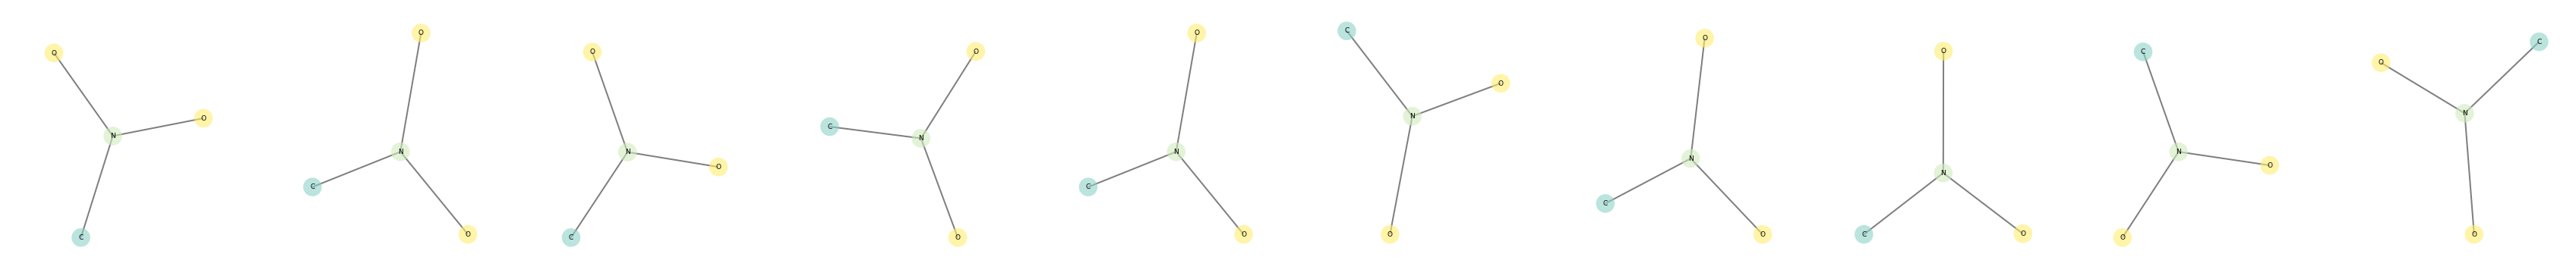

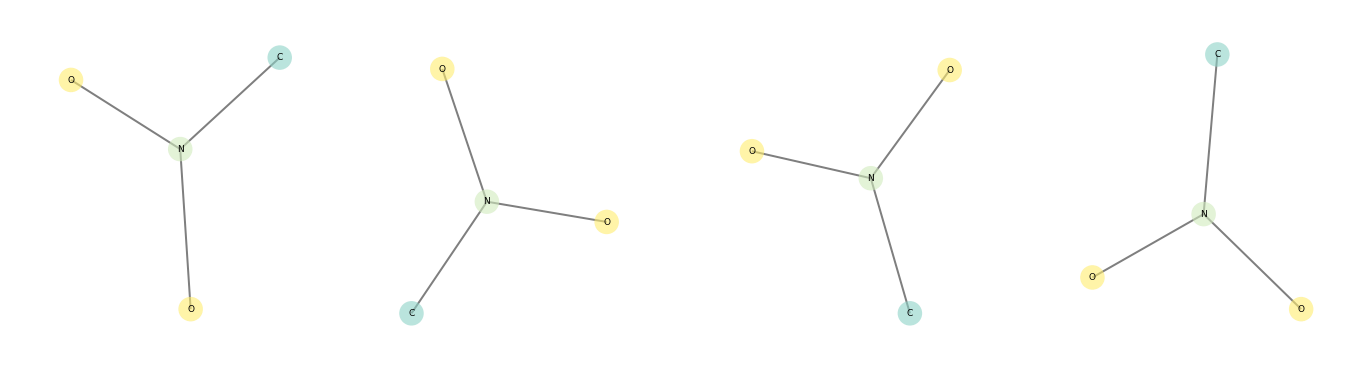

cluster id: 10  num: 17


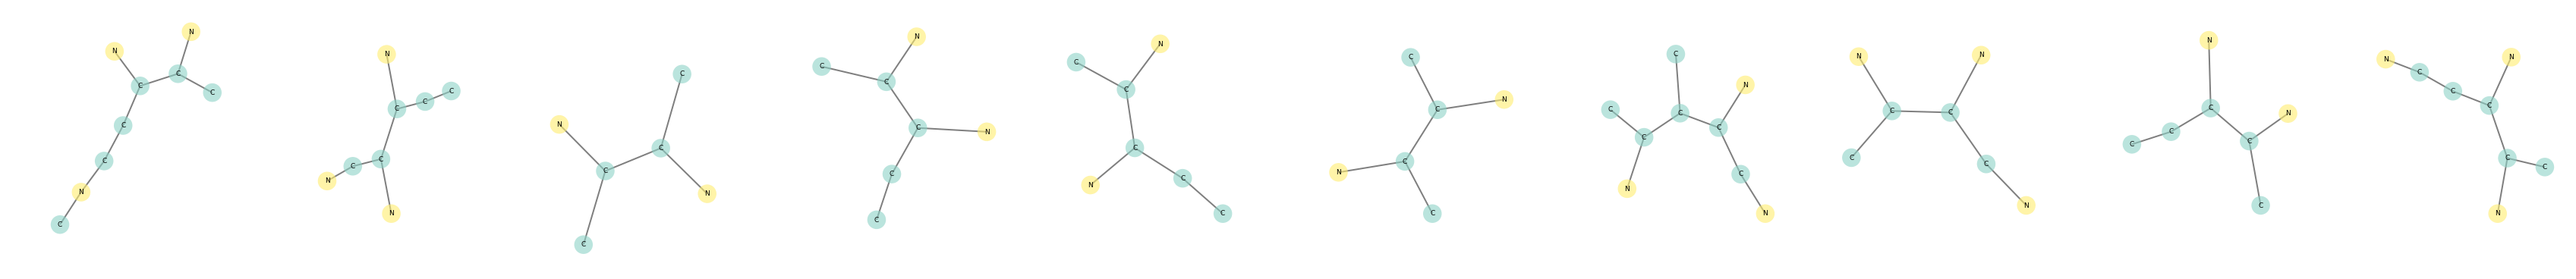

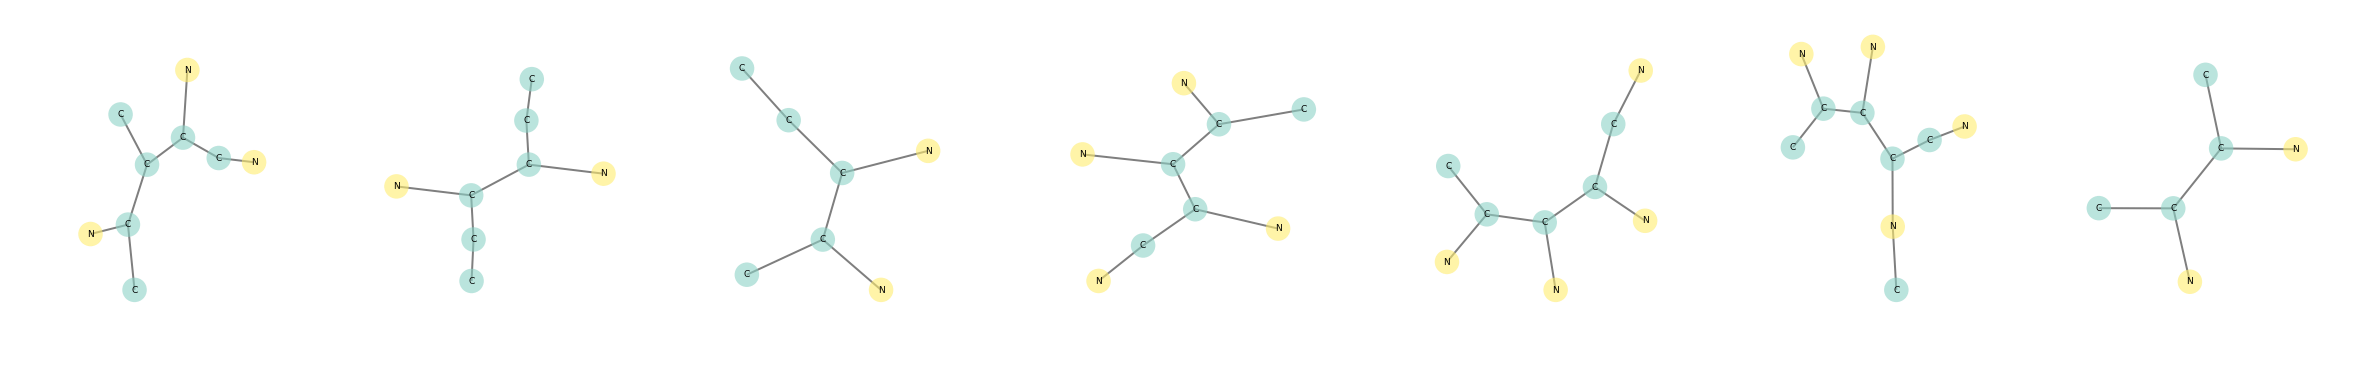

cluster id: 11  num: 3


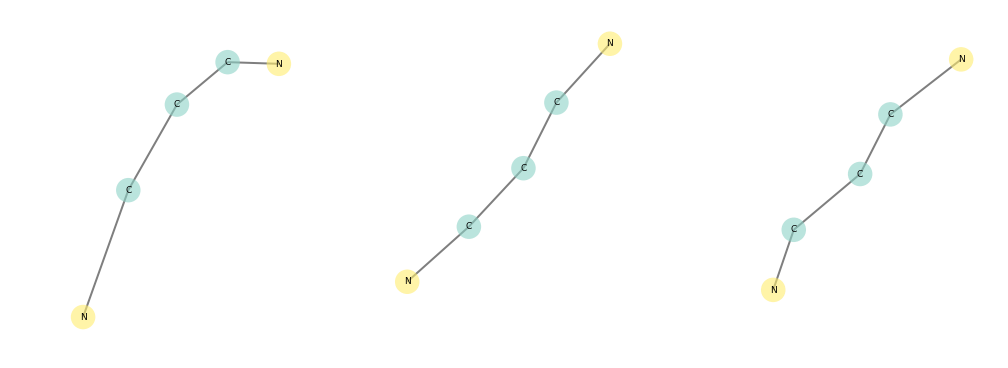

cluster id: 12  num: 19


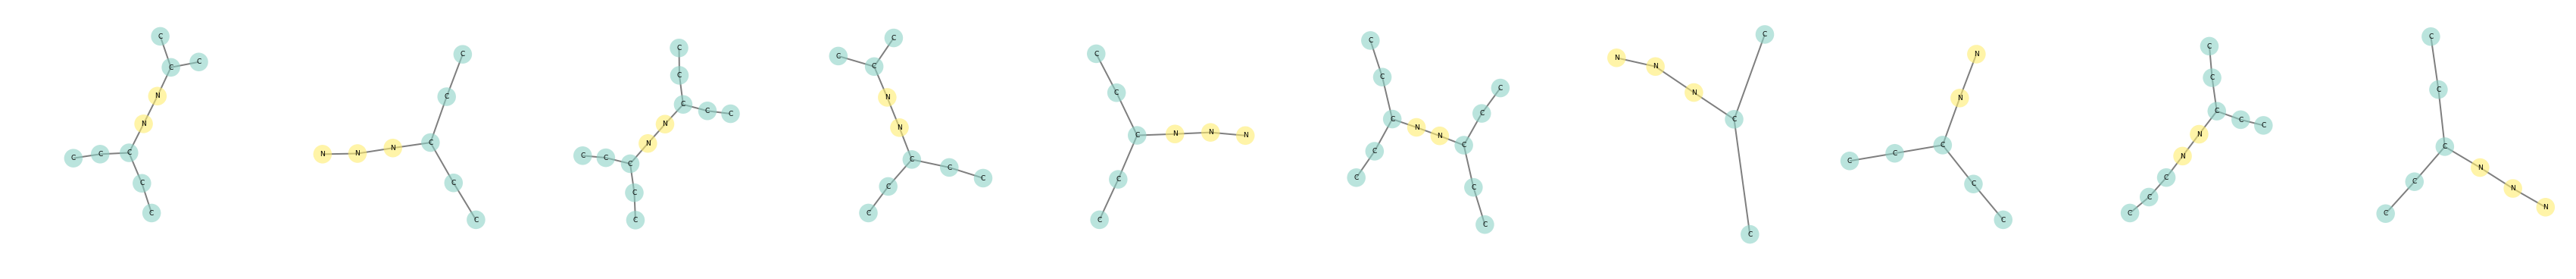

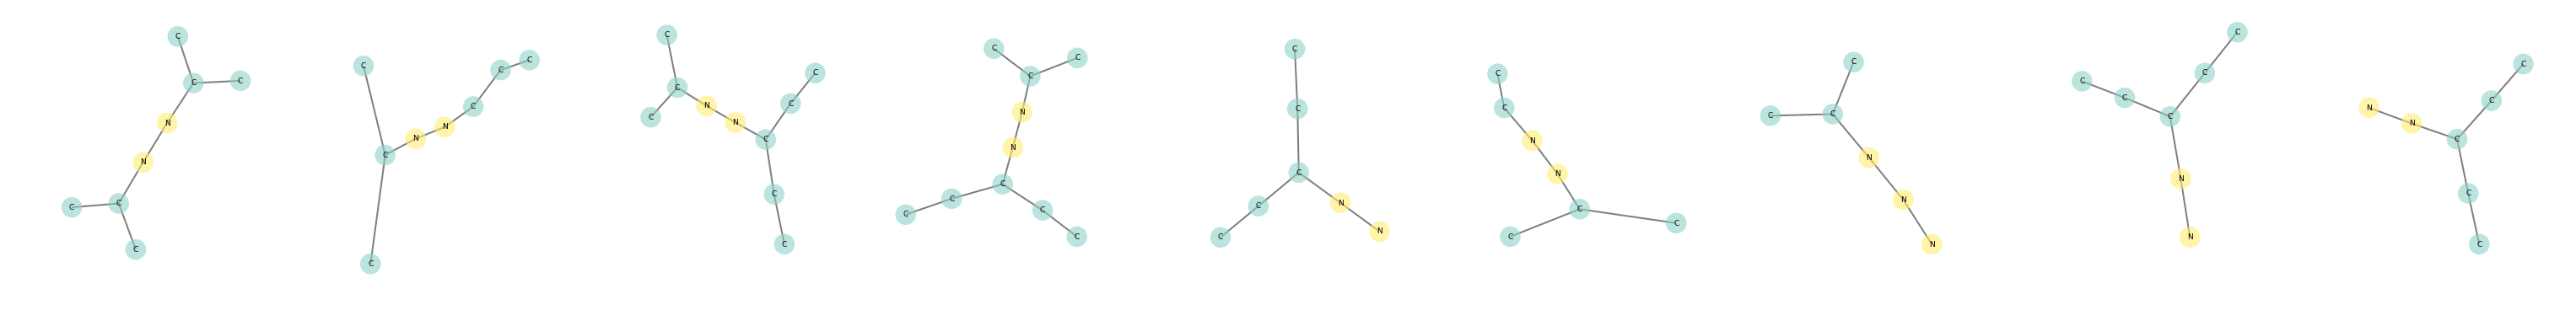

cluster id: 13  num: 19


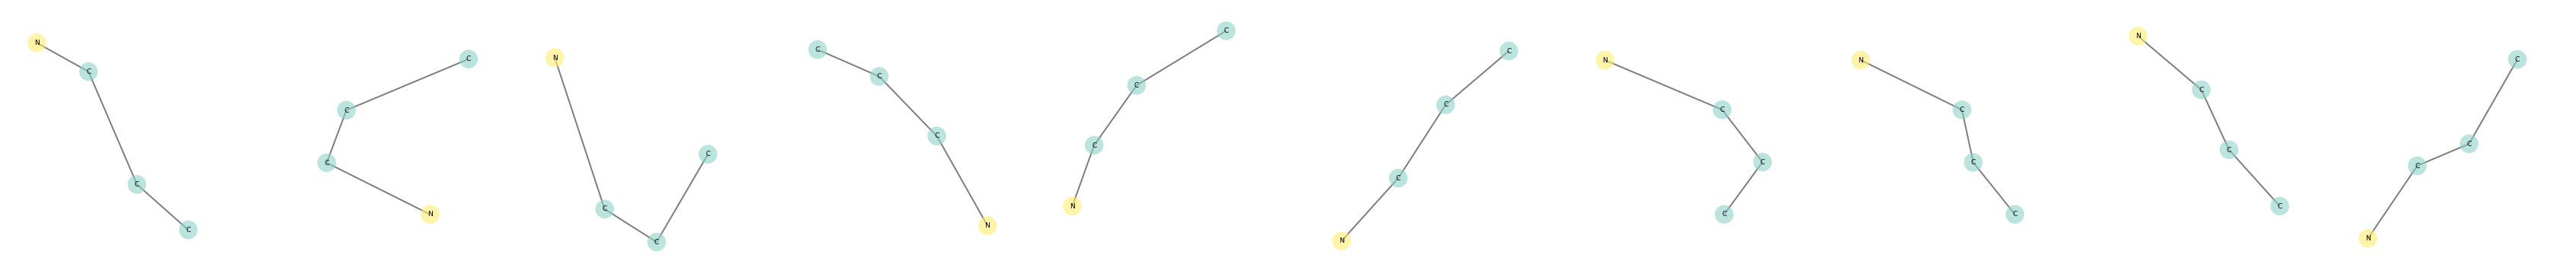

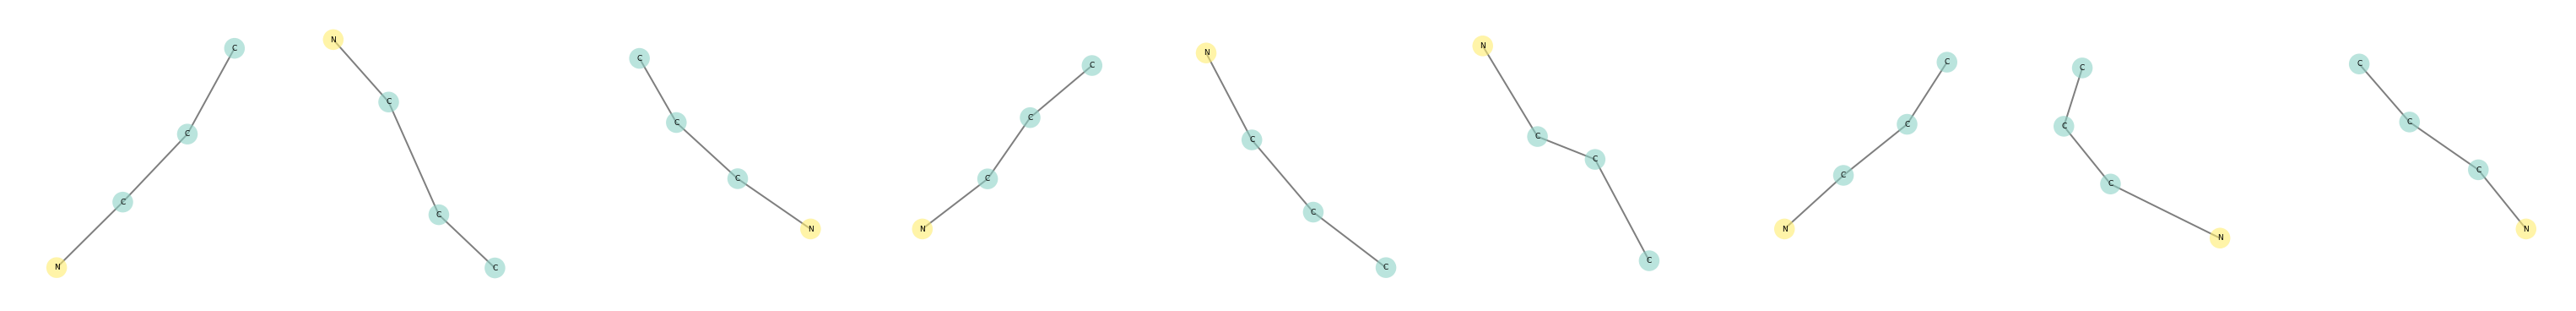

cluster id: 14  num: 12


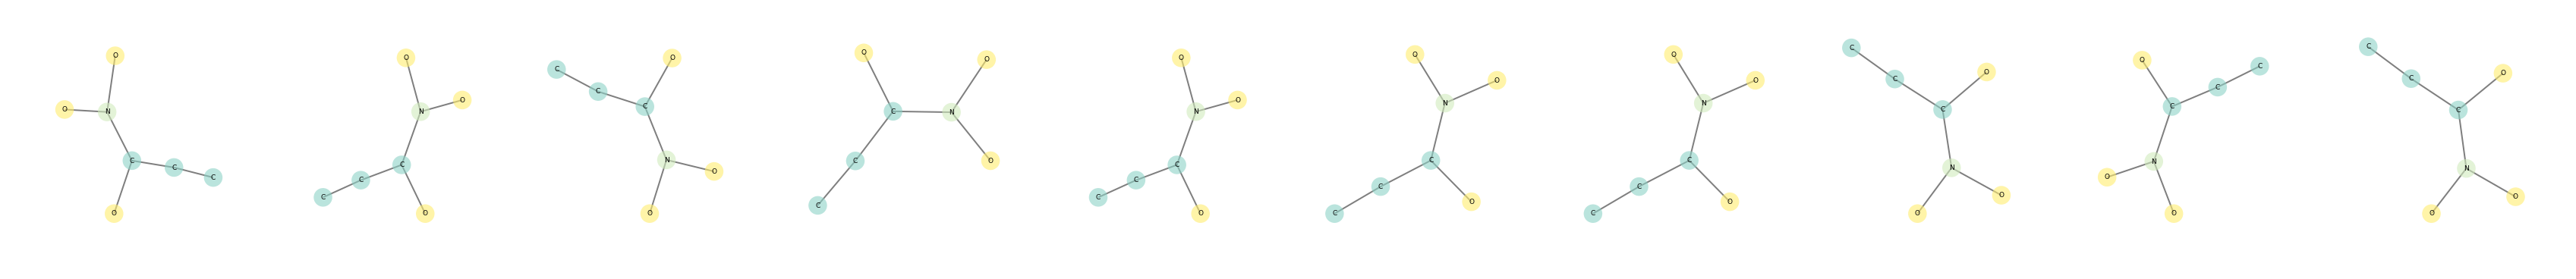

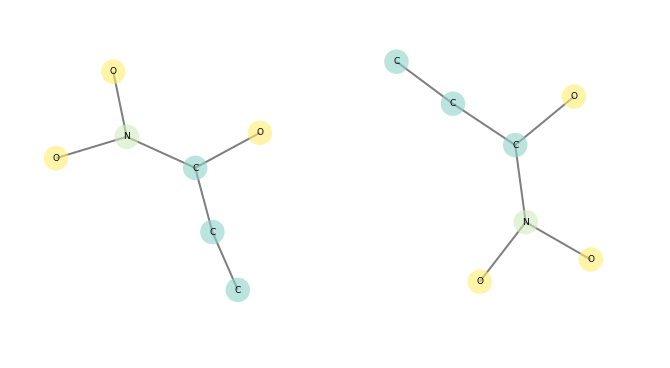

cluster id: 15  num: 6


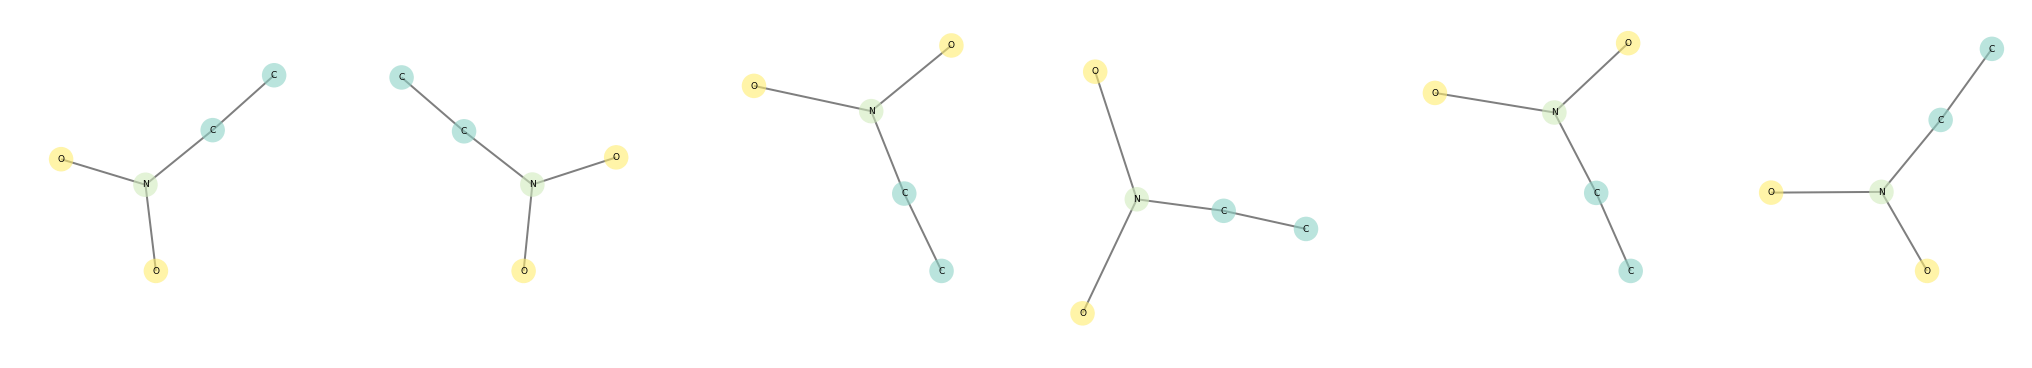

cluster id: 16  num: 32


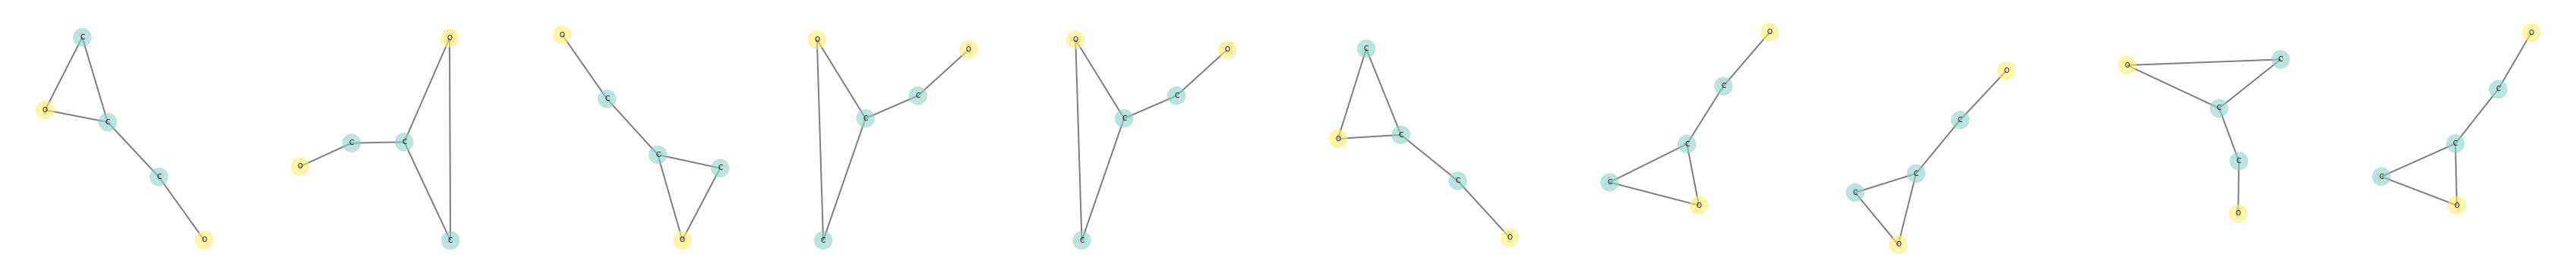

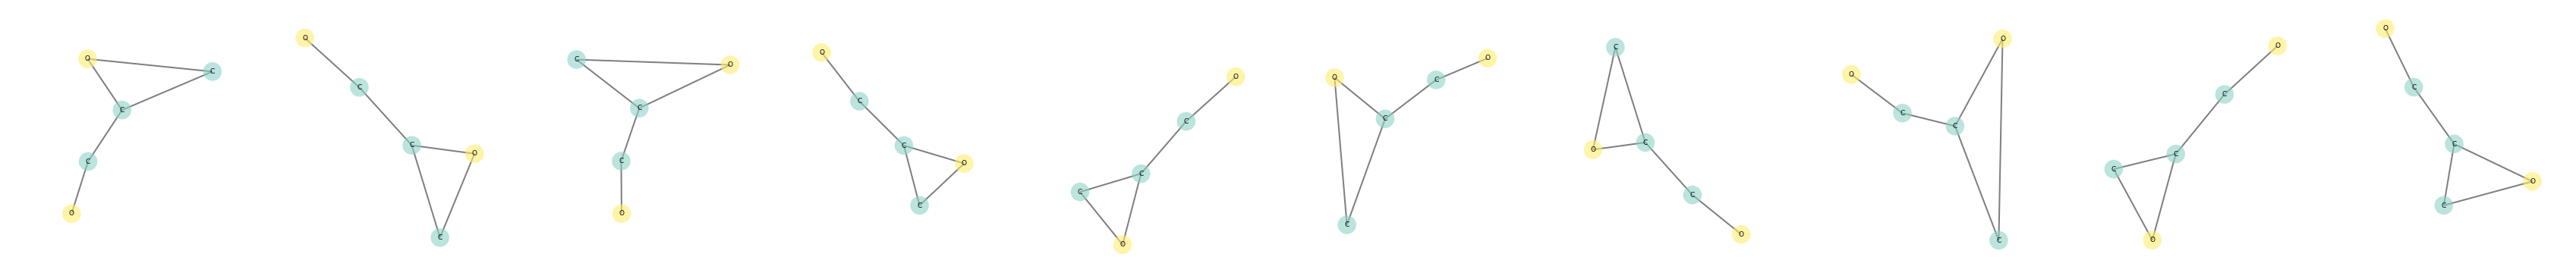

cluster id: 17  num: 3


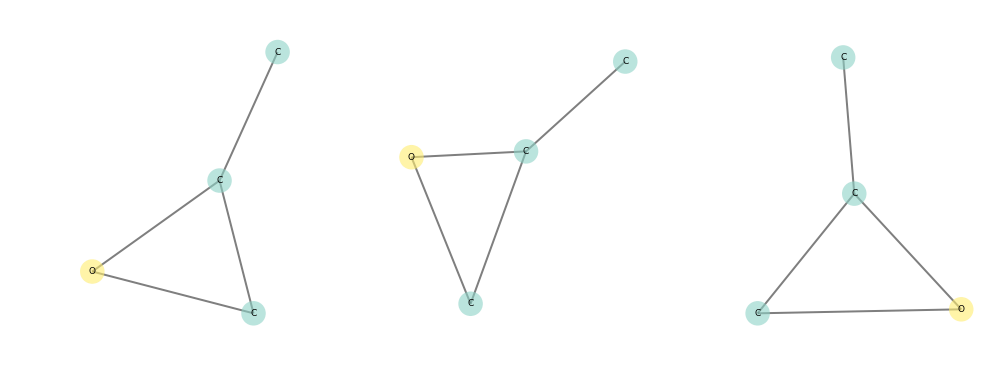

cluster id: 18  num: 5


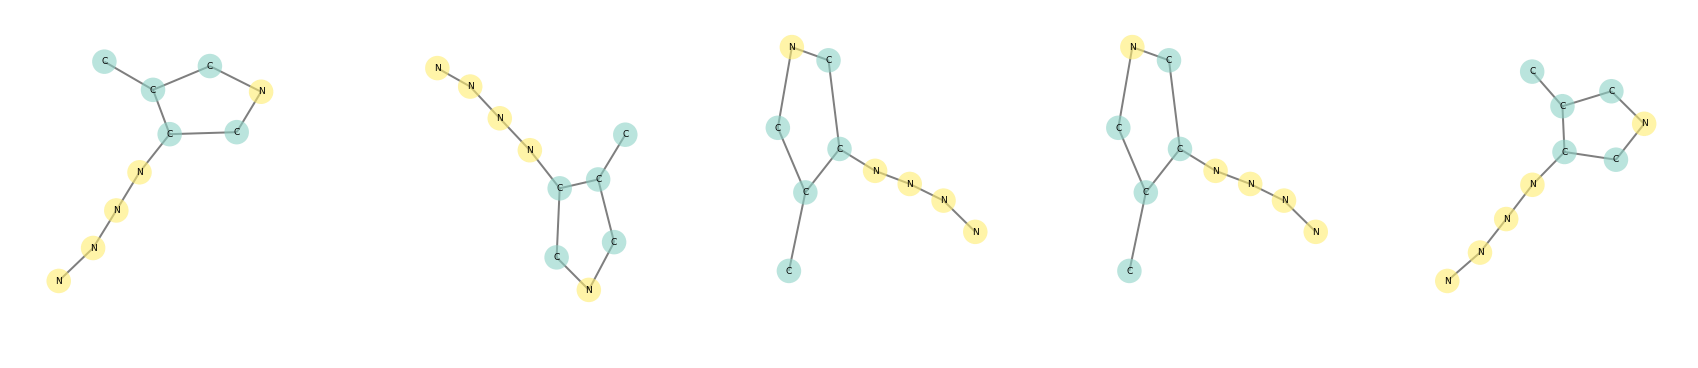

cluster id: 19  num: 4


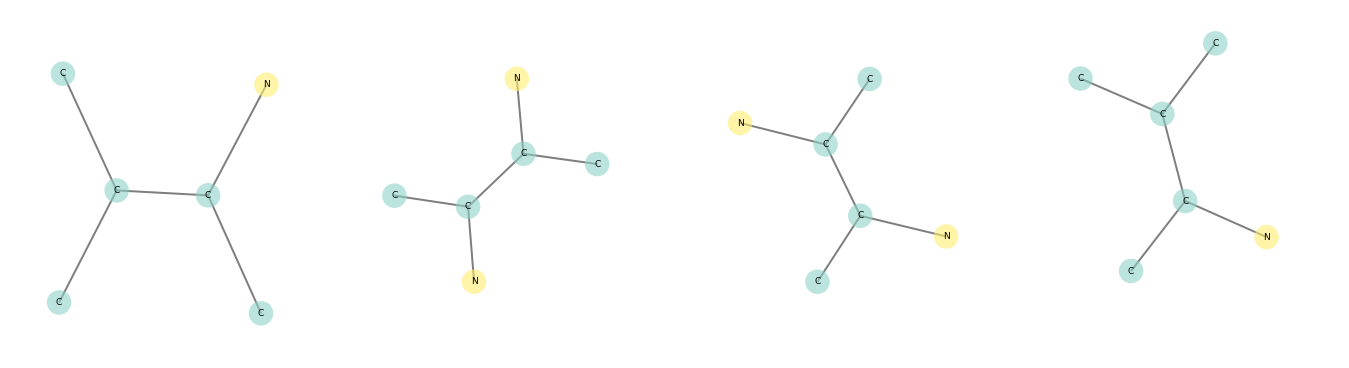

cluster id: 20  num: 9


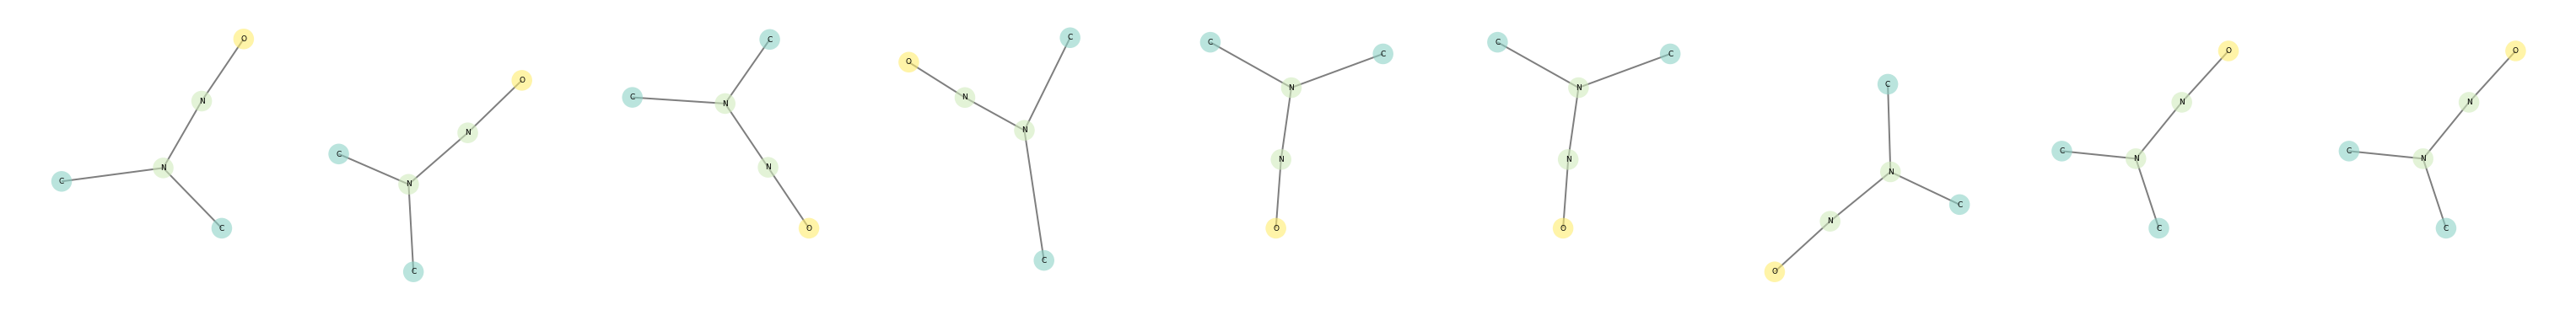

cluster id: 21  num: 26


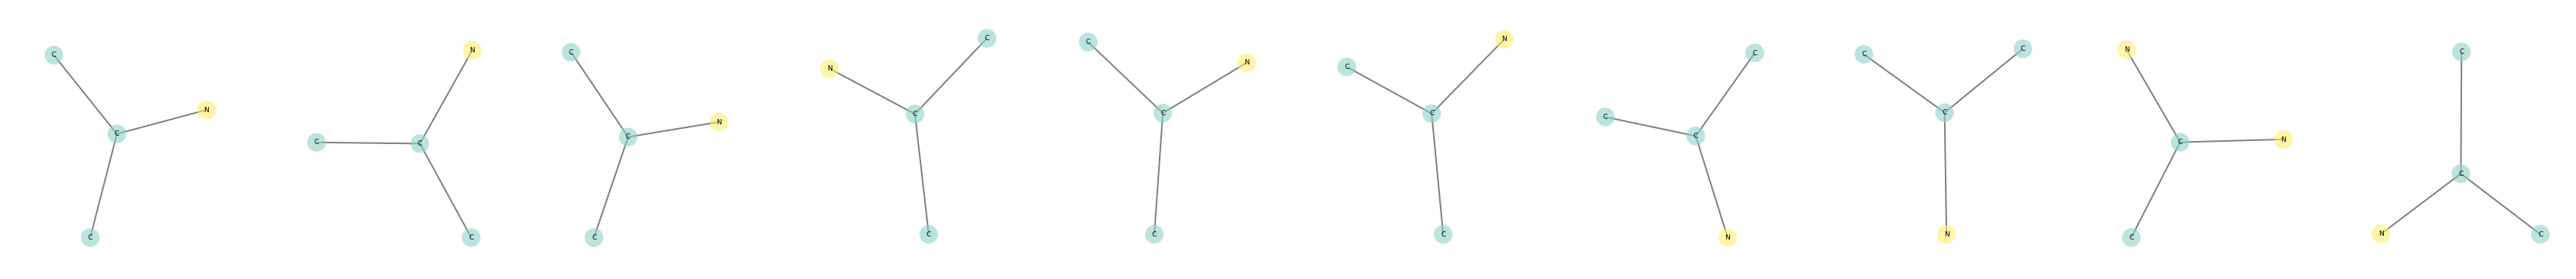

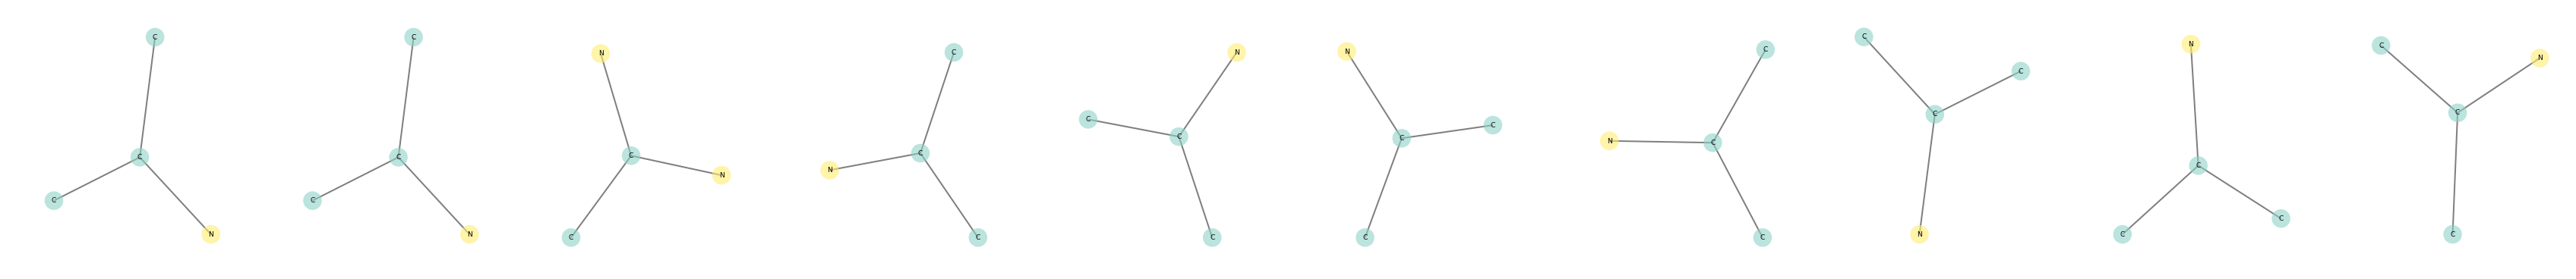

cluster id: 22  num: 18


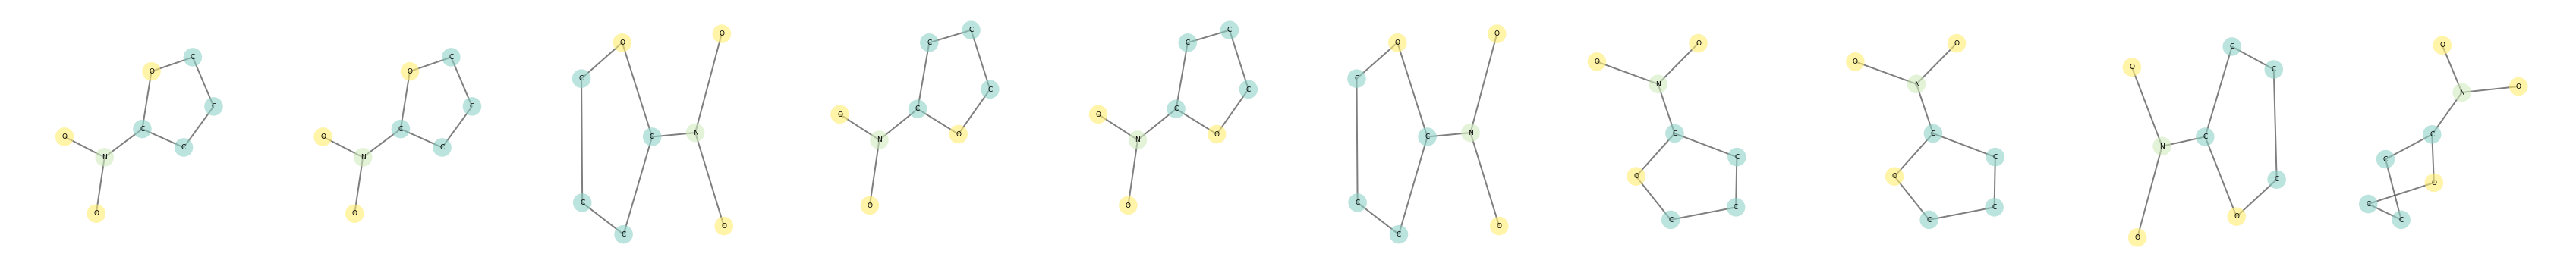

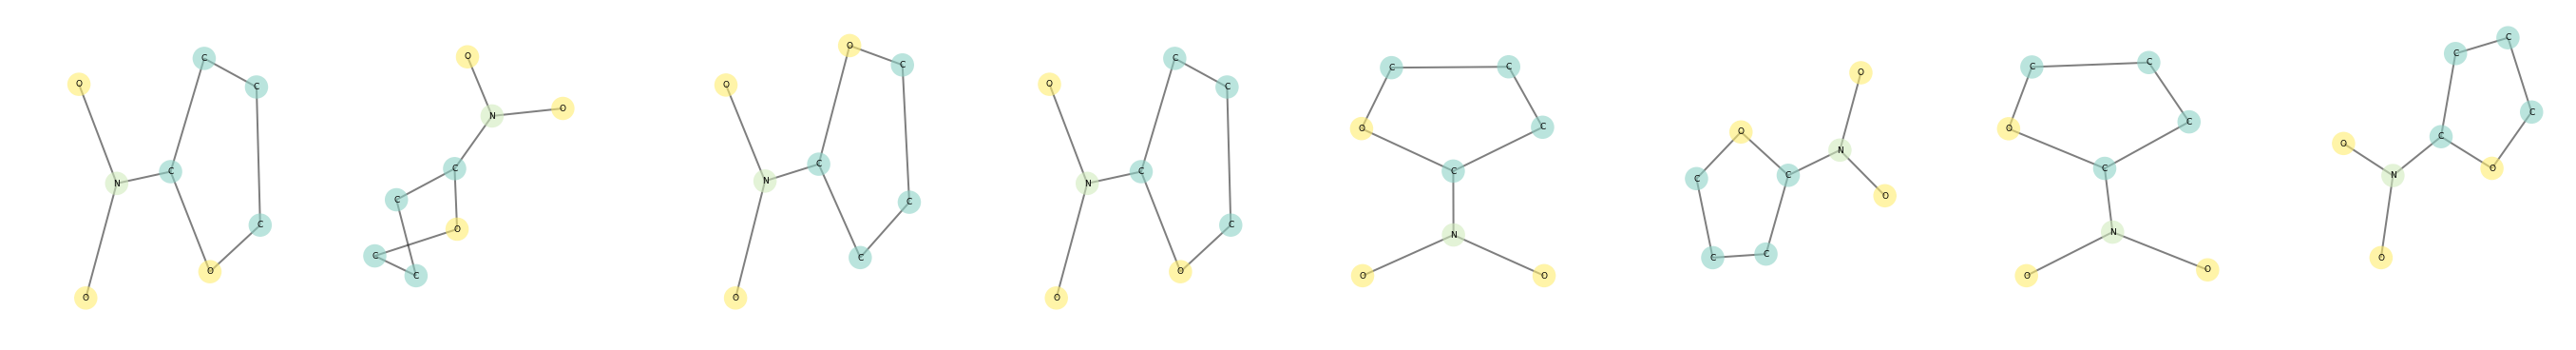

cluster id: 23  num: 8


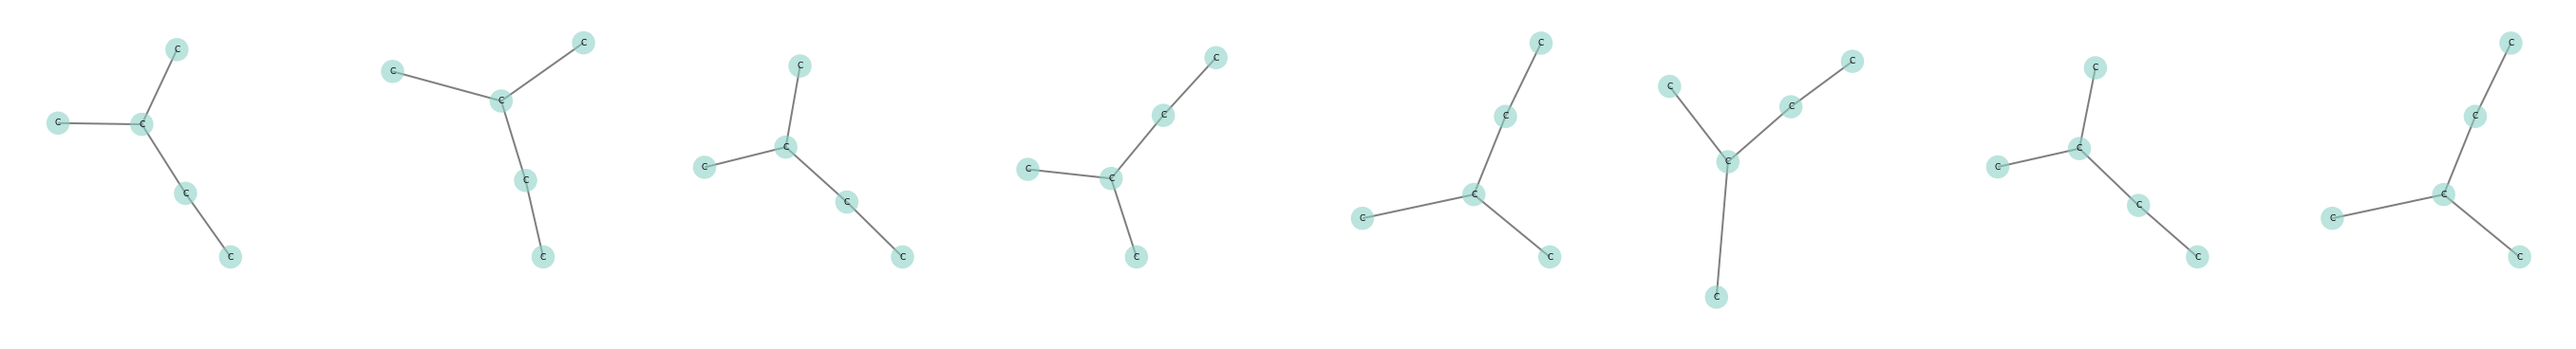

cluster id: 24  num: 5


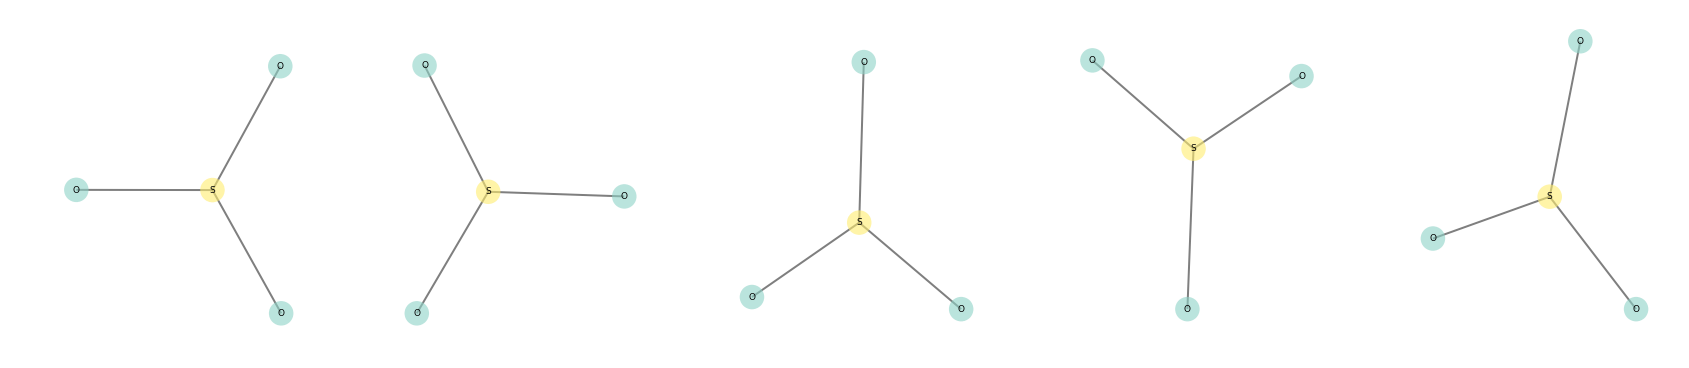

cluster id: 25  num: 21


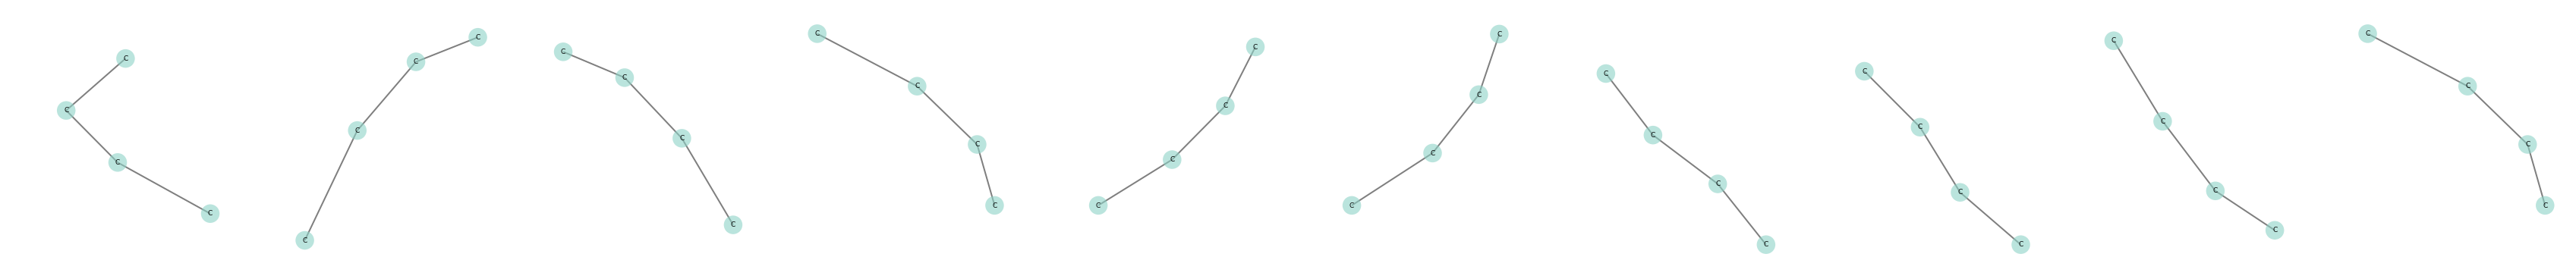

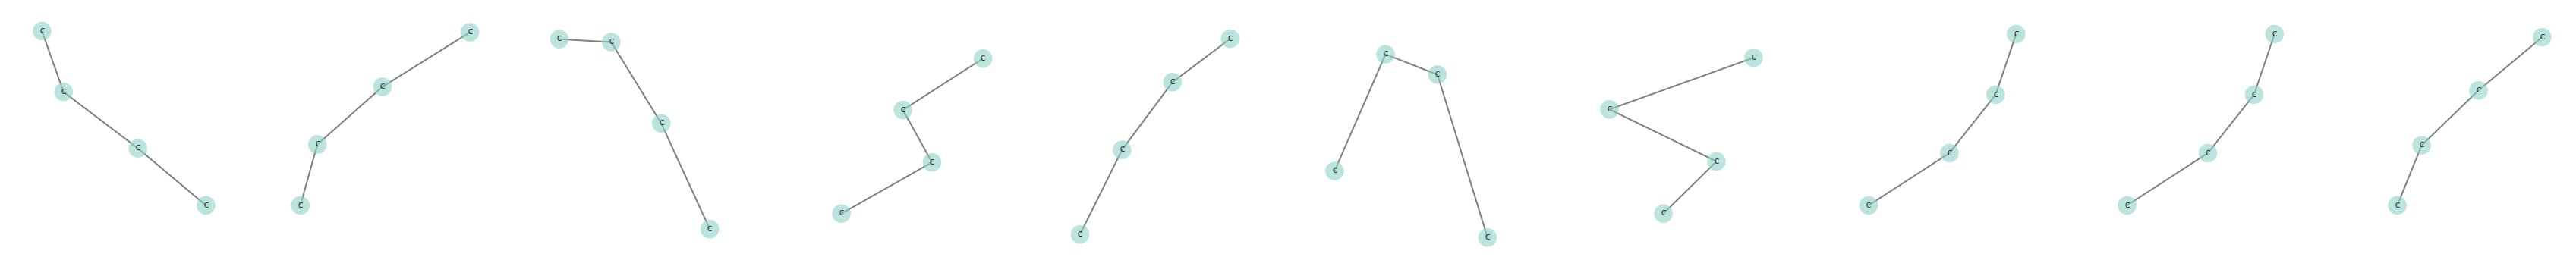

cluster id: 26  num: 6


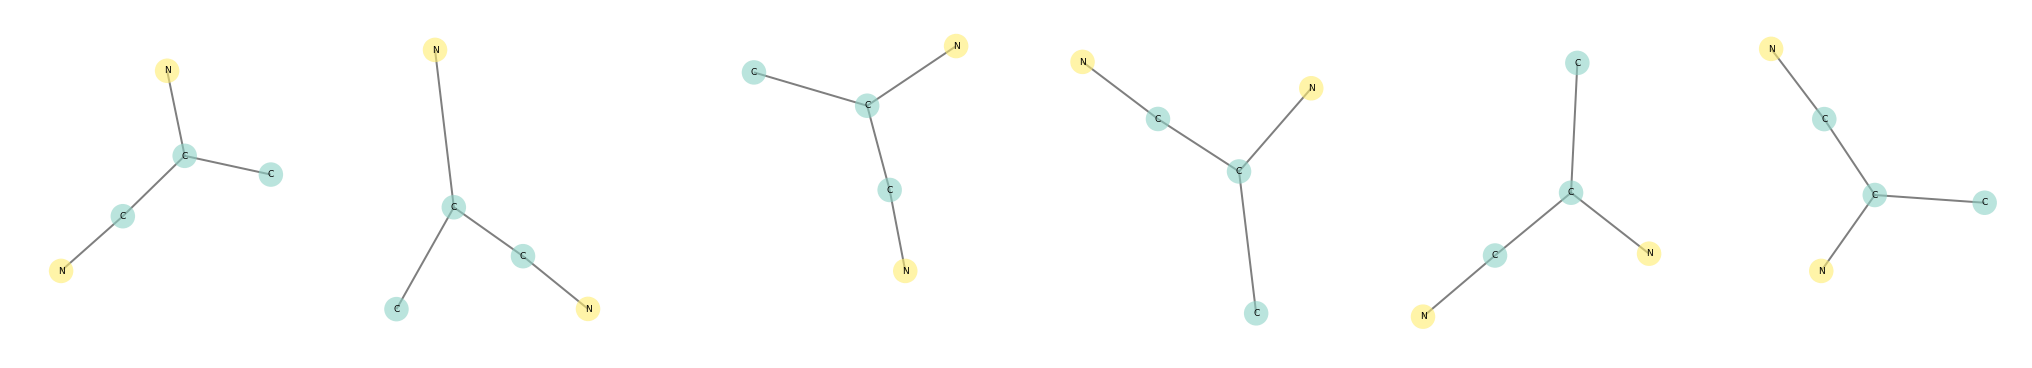

cluster id: 27  num: 8


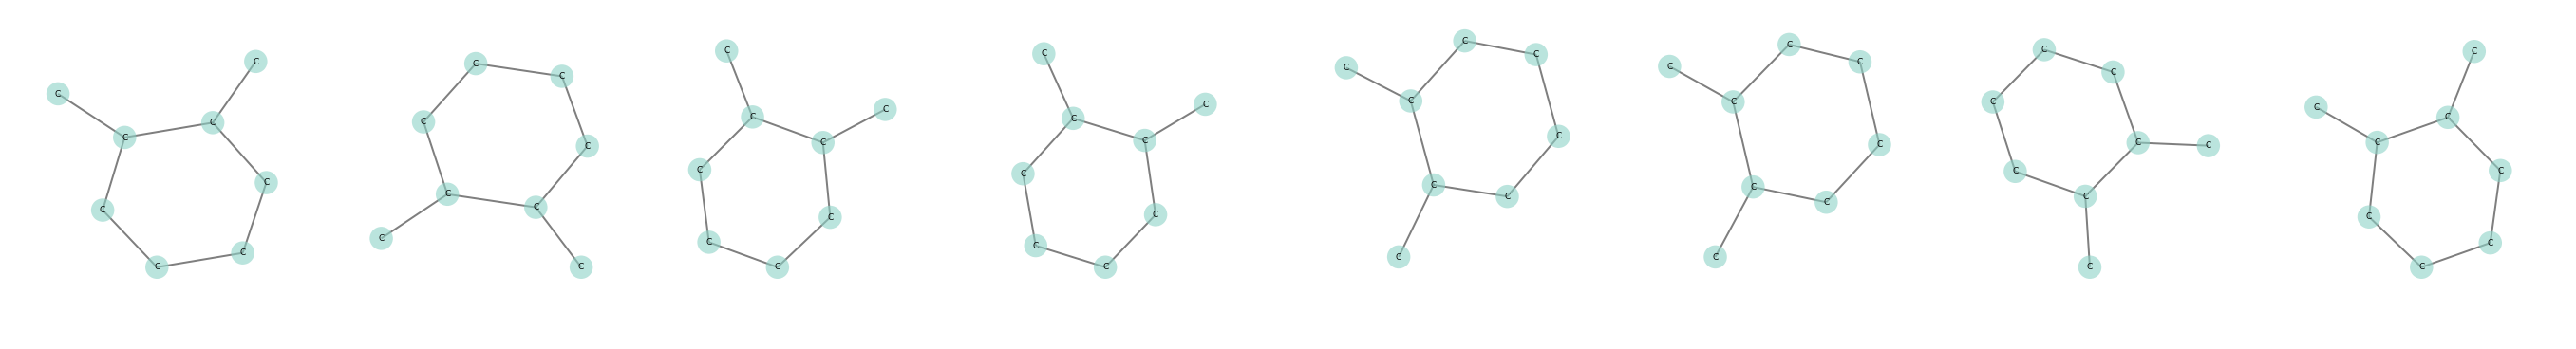

cluster id: 28  num: 4


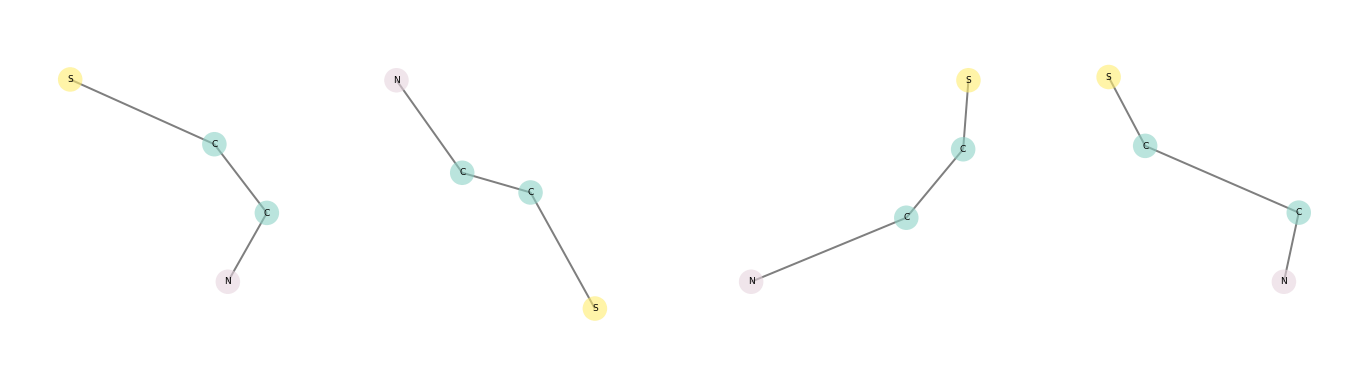

cluster id: 29  num: 3


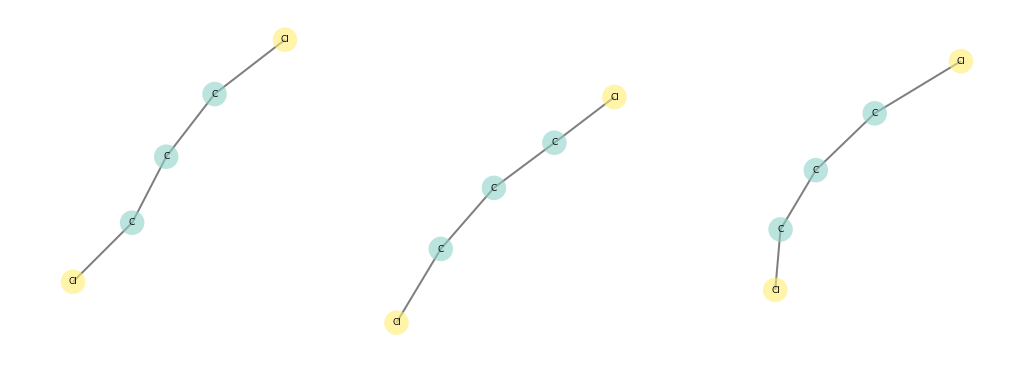

cluster id: 30  num: 3


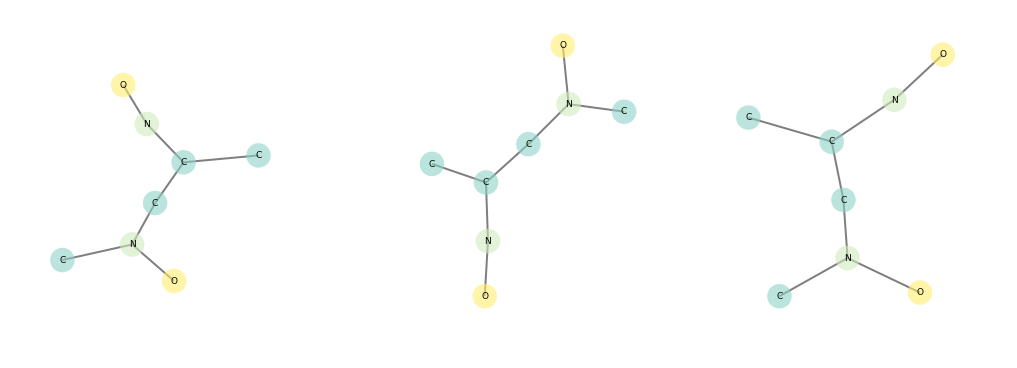

cluster id: 31  num: 5


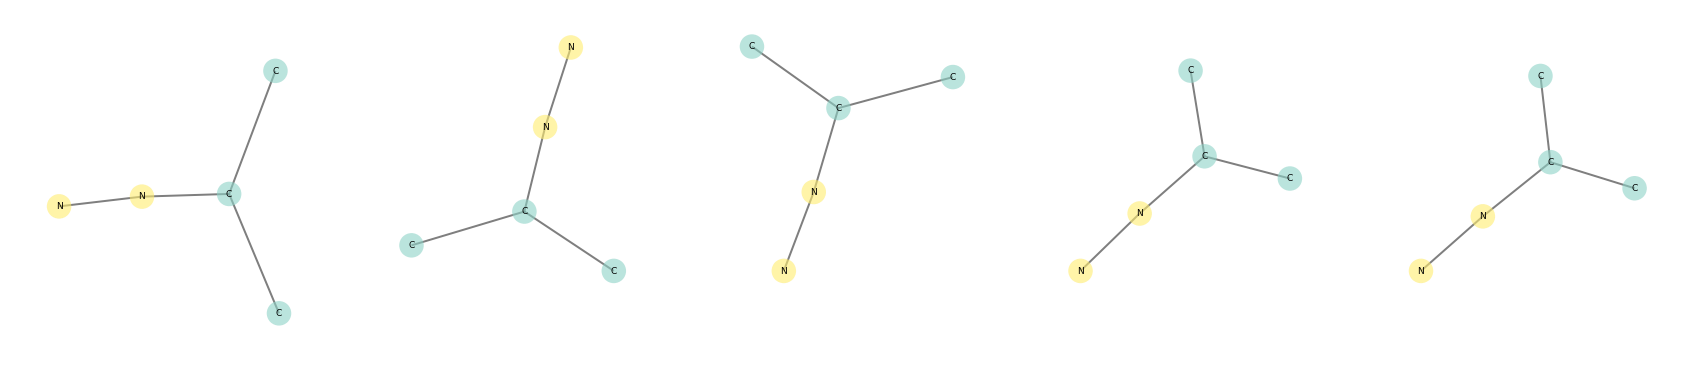

cluster id: 32  num: 7


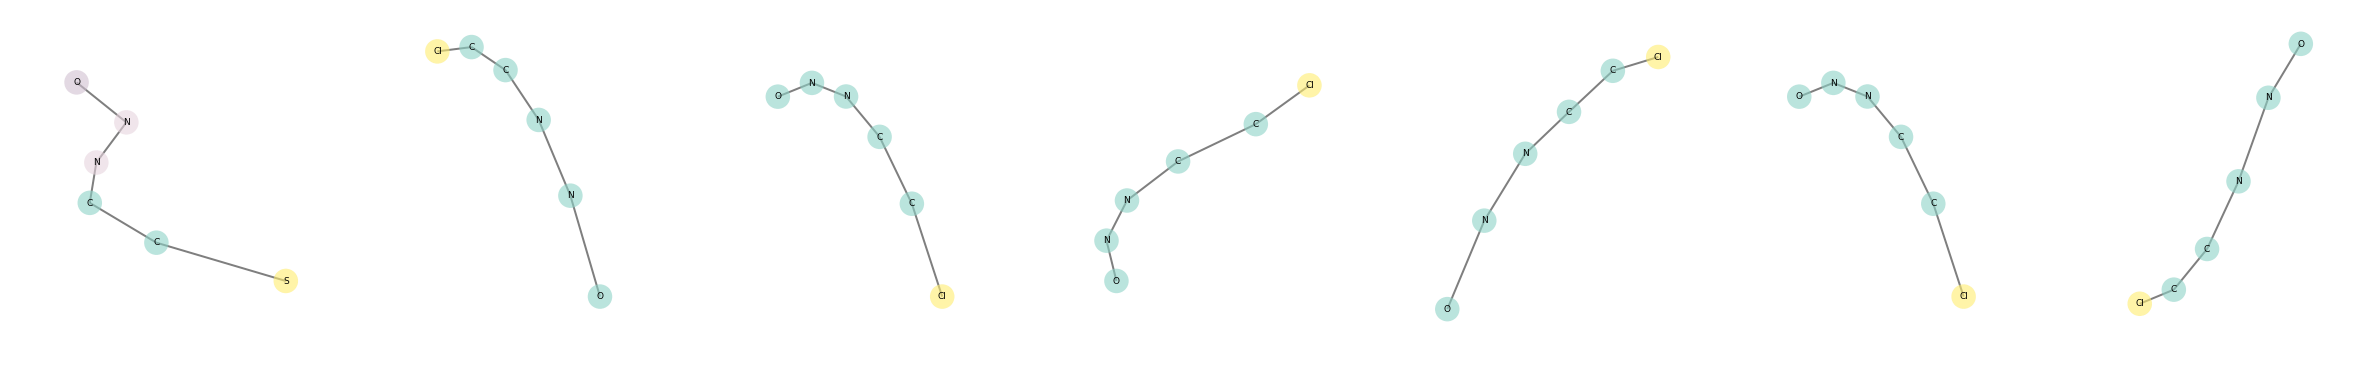

cluster id: 33  num: 3


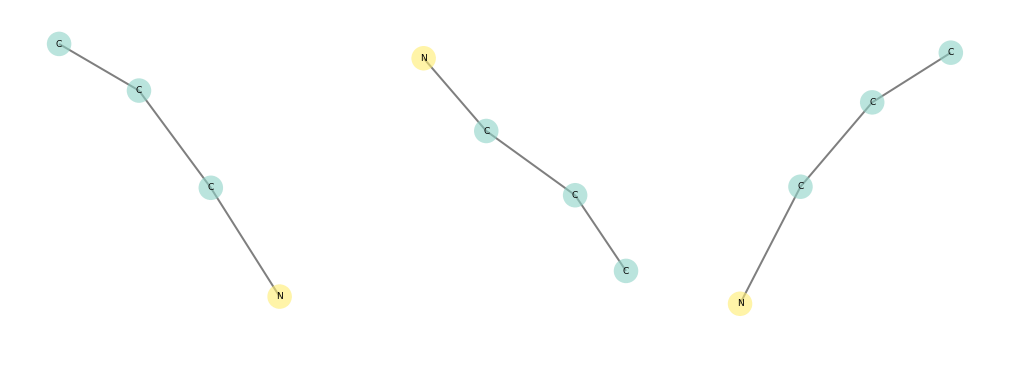

cluster id: 34  num: 3


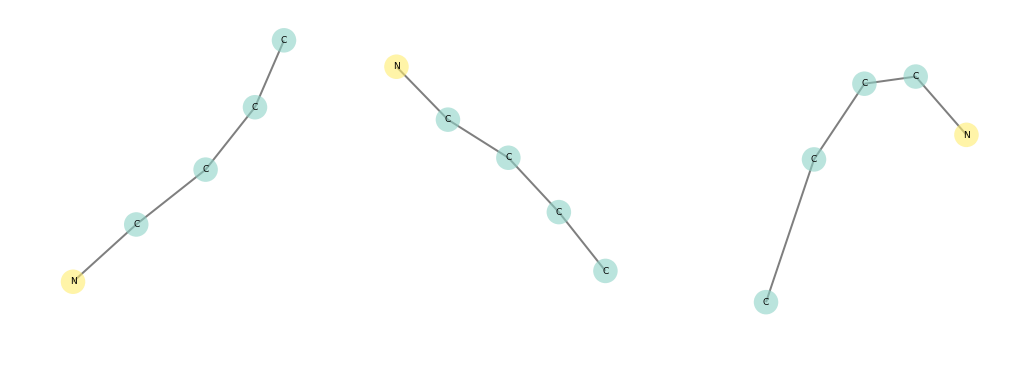

cluster id: 35  num: 5


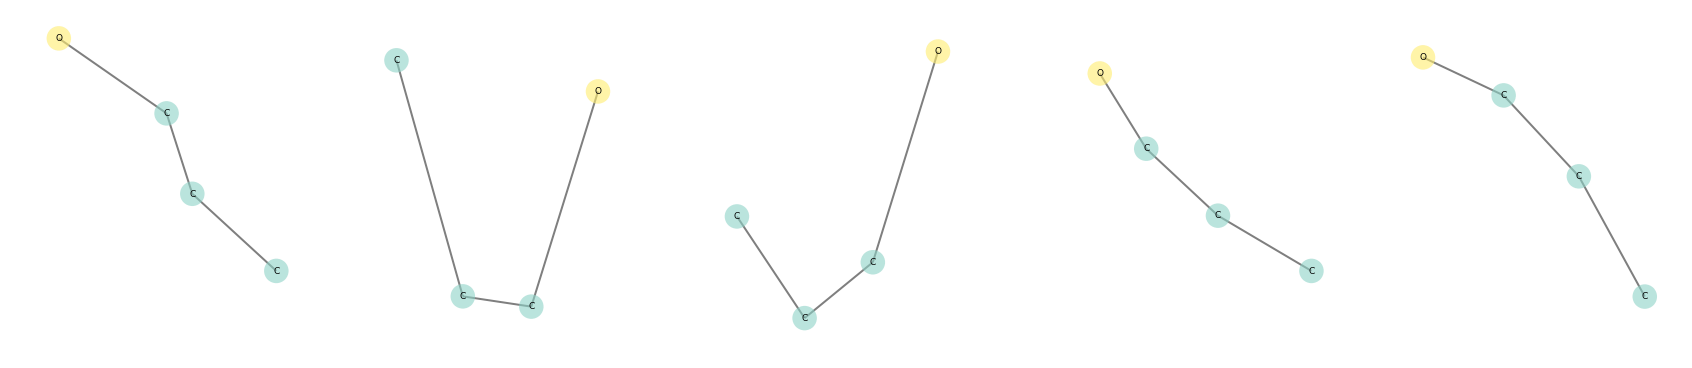

cluster id: 36  num: 3


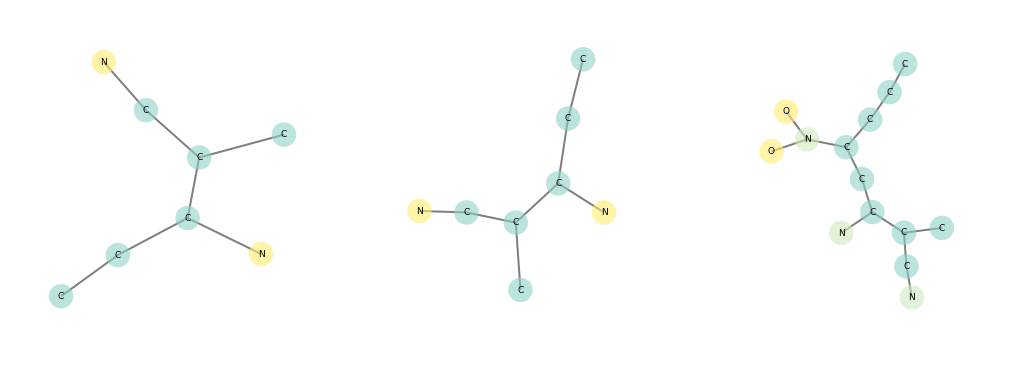

cluster id: 37  num: 3


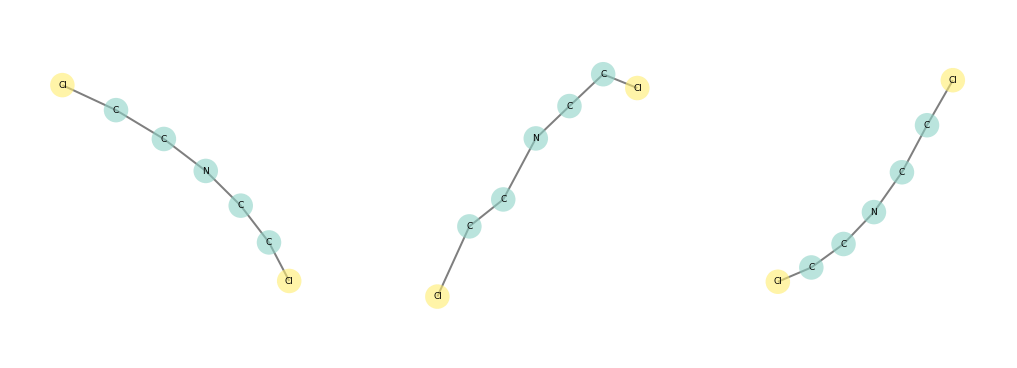

cluster id: 38  num: 3


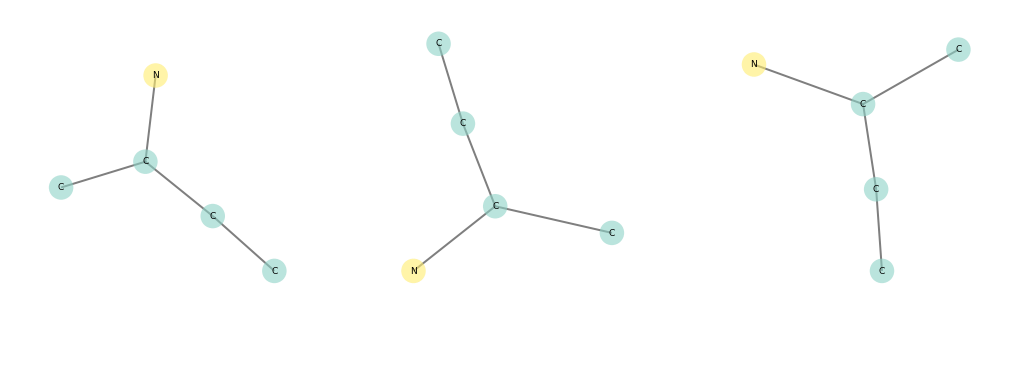

cluster id: 39  num: 3


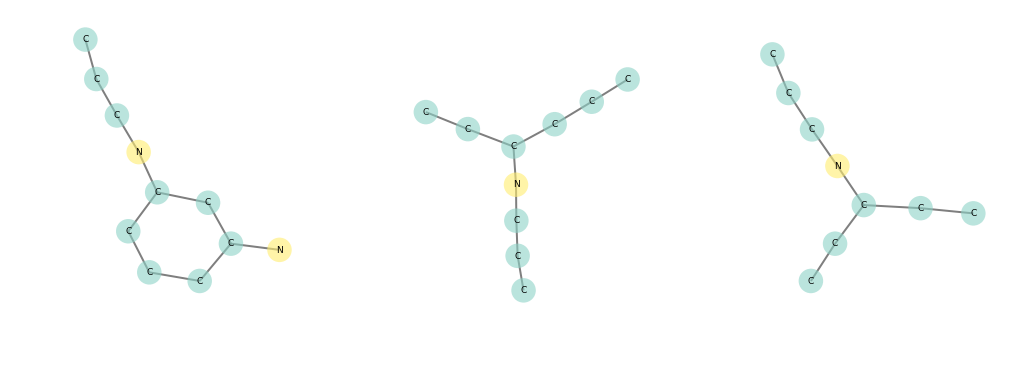

cluster id: -1  num: 116


In [39]:
from collections import defaultdict
clustered_graphs = defaultdict(list)
from itertools import izip
for cluster_id, graph in izip(cluster_ids, graphs):
    clustered_graphs[cluster_id].append(graph)

for cluster_id in clustered_graphs:
    logger.info('cluster id: %d  num: %d' % (cluster_id, len(clustered_graphs[cluster_id])))
    #data_matrix = vectorizer.transform(clustered_graphs[cluster_id])
    #distance_matrix = pairwise_distances(data_matrix)
    #print distance_matrix
    if cluster_id != -1:
        draw_graph_set(clustered_graphs[cluster_id][:20], n_graphs_per_line=10, size=6, vertex_color='_label_', prog='neato', colormap='Set3')

In [46]:
%%time
#multiclass logistic regression 
X = data_matrix
y = cluster_ids
#predict class
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight='balanced', 
                        random_state=None, 
                        solver='liblinear', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1)

#predictions computation
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, n_folds=5)
results=[]
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    probs = lr.predict_proba(X_test)
    targets = lr.predict(X_test)
    results += [(i,prob, target) for i, prob, target in zip(test_index, probs, targets)]
preds = np.array([prob for i,prob,target in sorted(results)])
targs = np.array([target for i,prob,target in sorted(results)])

CPU times: user 1min 10s, sys: 4.42 s, total: 1min 14s
Wall time: 1min 14s


/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [48]:
for t,p,v in zip(targs,preds,y):
    print v,t,p

0 0 [ 0.03315948  0.46283385  0.00888683  0.029812    0.00796378  0.00830587
  0.00932558  0.03065387  0.00808929  0.00851949  0.00789307  0.02015518
  0.04634959  0.01117535  0.01904831  0.00745692  0.00896282  0.0091236
  0.00828514  0.00810054  0.0101068   0.00821262  0.00950965  0.00842213
  0.00742863  0.00860009  0.00984817  0.02368414  0.01024033  0.03062031
  0.00978018  0.00756765  0.00813866  0.00911528  0.01679982  0.02239822
  0.00873908  0.00944531  0.0095082   0.00910805  0.00862614]
-1 -1 [ 0.08013605  0.01419707  0.01417802  0.0626042   0.01649137  0.051842
  0.01573235  0.0150163   0.05416442  0.01833036  0.01711482  0.02055494
  0.01500975  0.07927504  0.01455854  0.01730817  0.0179215   0.0159481
  0.01707772  0.0290724   0.01846605  0.02524084  0.01801816  0.01451177
  0.02926464  0.01843948  0.02245328  0.01632977  0.01639659  0.01457214
  0.01472178  0.0249763   0.01982855  0.0390866   0.0150497   0.01391384
  0.01671039  0.01590957  0.01578713  0.0157523   0.0280

---